<a href="https://colab.research.google.com/github/chaumintruong/AIO_Module2_Image_Retrieval/blob/feature%2Fproject_IR/Image_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thu Thập và Xử Lý Dữ Liệu Để Xây Dựng Chương Trình Truy Vấn Ảnh Cá Nhân Hóa

## Cài đặt các thư viện cần thiết

In [1]:
!pip install tqdm selenium
!apt-get update
!apt-get install -y wget chromium-browser chromium-chromedriver


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.9 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://security.ubuntu.com/ubun

## Import thư viện cần thiết

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import urllib.request
import time
import os
from tqdm import tqdm
import concurrent.futures
import json
from PIL import Image


## Lớp `UrlScraper` để crawl URL ảnh

In [3]:
class UrlScraper:
    def __init__(self, url_template, max_images=50, max_workers=4):
        self.url_template = url_template
        self.max_images = max_images
        self.max_workers = max_workers
        self.setup_environment()

    def setup_environment(self):
        os.environ['PATH'] += ':/usr/lib/chromium-browser/'
        os.environ['PATH'] += ':/usr/lib/chromium-browser/chromedriver/'

    def get_url_images(self, term):
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument('--disable-dev-shm-usage')
        driver = webdriver.Chrome(options=options)
        url = self.url_template.format(search_term=term)
        driver.get(url)

        urls = []
        more_content_available = True
        pbar = tqdm(total=self.max_images, desc=f"Fetching images for {term}")

        while len(urls) < self.max_images and more_content_available:
            soup = BeautifulSoup(driver.page_source, "html.parser")
            img_tags = soup.find_all("img")
            for img in img_tags:
                if len(urls) >= self.max_images:
                    break
                if 'src' in img.attrs:
                    href = img.attrs['src']
                    img_path = urljoin(url, href)
                    img_path = img_path.replace("_m.jpg", "_b.jpg").replace("_n.jpg", "_b.jpg").replace("_w.jpg", "_b.jpg")
                    if img_path == "https://combo.staticflickr.com/ap/build/images/getty/IStock_corporate_logo.svg":
                        continue
                    urls.append(img_path)
                    pbar.update(1)

            try:
                load_more_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, '//button[@id="yui_3_16_0_1_1721642285931_28620"]'))
                )
                load_more_button.click()
                time.sleep(2)
            except:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)

            new_soup = BeautifulSoup(driver.page_source, "html.parser")
            new_img_tags = new_soup.find_all("img", loading_="lazy")
            if len(new_img_tags) == len(img_tags):
                more_content_available = False
            img_tags = new_img_tags

        pbar.close()
        driver.quit()
        return urls

    def scrape_urls(self, categories):
        all_urls = {category: {} for category in categories}
        with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            future_to_term = {executor.submit(self.get_url_images, term): (category, term)
                              for category, terms in categories.items() for term in terms}
            for future in tqdm(concurrent.futures.as_completed(future_to_term), total=len(future_to_term), desc="Overall Progress"):
                category, term = future_to_term[future]
                try:
                    urls = future.result()
                    all_urls[category][term] = urls
                    print(f"\nNumber of images retrieved for {term}: {len(urls)}")
                except Exception as exc:
                    print(f"\n{term} generated an exception: {exc}")
        return all_urls

    def save_to_file(self, data, filename):
        with open(filename, 'w') as file:
            json.dump(data, file, indent=4)
        print(f"Data saved to {filename}")


## Lớp `ImageDownloader` để tải ảnh từ URL

In [4]:
class ImageDownloader:
    def __init__(self, json_file, download_dir='Dataset', max_workers=4, delay=1):
        self.json_file = json_file
        self.download_dir = download_dir
        self.max_workers = max_workers
        self.delay = delay
        self.filename = set()
        self.setup_directory()

    def setup_directory(self):
        if not os.path.exists(self.download_dir):
            os.makedirs(self.download_dir)

    def read_json(self):
        with open(self.json_file, 'r') as file:
            data = json.load(file)
        return data

    def is_valid_url(self, url):
        try:
            with urllib.request.urlopen(url) as response:
                if response.status == 200 and 'image' in response.info().get_content_type():
                    return True
        except Exception:
            return False

    def download_image(self, url, category, term, pbar):
        if not self.is_valid_url(url):
            pbar.update(1)
            return f"Invalid URL: {url}"

        category_dir = os.path.join(self.download_dir, category)
        if not os.path.exists(category_dir):
            os.makedirs(category_dir)

        term_dir = os.path.join(category_dir, term)
        if not os.path.exists(term_dir):
            os.makedirs(term_dir, exist_ok=True)

        filename = os.path.join(term_dir, os.path.basename(urlparse(url).path))
        self.filename.add(filename)

        try:
            urllib.request.urlretrieve(url, filename)
            pbar.update(1)
            return f"Downloaded: {url}"
        except Exception as e:
            pbar.update(1)
            return f"Failed to download {url}: {str(e)}"

    def download_images(self):
        data = self.read_json()
        download_tasks = []
        total_images = sum(len(urls) for terms in data.values() for urls in terms.values())
        with tqdm(total=total_images, desc="Downloading images") as pbar:
            with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers) as executor:
                for category, terms in data.items():
                    for term, urls in terms.items():
                        for url in urls:
                            download_tasks.append(executor.submit(self.download_image, url, category, term, pbar))
                        time.sleep(self.delay)

                for future in concurrent.futures.as_completed(download_tasks):
                    print(future.result())

        self.export_filename()

    def export_filename(self):
        with open('filename.txt', 'w') as file:
            for filename in sorted(self.filename):
                file.write(f"{filename}\n")


## Sử dụng chương trình

In [7]:
categories = {
    "animal": ["Monkey", "Elephant", "Cows", "Cat", "Dog", "Bear", "Fox", "Civet", "Pangolins", "Rabbit", "Bats", "Whale", "Cock", "Owl", "flamingo", "Lizard", "Turtle", "Snake", "Frog", "Fish", "shrimp", "Crab", "Snail", "Coral", "Jellyfish", "Butterfly", "Flies", "Mosquito", "Ants", "Cockroaches", "Spider", "scorpion", "tiger", "bird", "horse", "pig", "Alligator", "Alpaca", "Anteater", "donkey", "Bee", "Buffalo", "Camel", "Caterpillar", "Cheetah", "Chicken", "Dragonfly", "Duck", "panda", "Giraffe"],
    "plant": ["Bamboo", "Apple", "Banana", "Bean", "Wildflower", "Flower", "Mushroom", "Weed", "Fern", "Grass", "Palmtree", "Corn", "Tulip", "Rose", "Clove", "Dogwood", "Durian", "Ferns", "Fig", "Flax", "Frangipani", "Lantana", "Hibiscus", "Bougainvillea", "Pea", "OrchidTree", "RangoonCreeper", "Jackfruit", "Cottonplant", "Corneliantree", "Coffeeplant", "Coconut", "wheat", "watermelon", "radish", "carrot"],
    "furniture": ["bed", "cabinet", "chair", "chests", "clock", "desks", "table", "Piano", "Bookcase", "Umbrella", "Clothes", "cart", "sofa", "ball", "spoon", "Bowl", "fridge", "pan", "book"],
    "scenery": ["Cliff", "Bay", "Coast", "Mountains", "Forests", "Waterbodies", "Lake", "desert", "farmland", "river", "hedges", "plain", "sky", "cave", "cloud", "flowergarden", "glacier", "grassland", "horizon", "lighthouse", "plateau", "savannah", "valley", "volcano", "waterfall"]
}

urltopic = {"flickr": "https://www.flickr.com/search/?text={search_term}"}
scraper = UrlScraper(url_template=urltopic["flickr"], max_images=20, max_workers=5)
image_urls = scraper.scrape_urls(categories)
scraper.save_to_file(image_urls, 'image_urls.json')

downloader = ImageDownloader(json_file='image_urls.json', download_dir='Dataset', max_workers=4, delay=1)
downloader.download_images()


Overall Progress:   1%|          | 1/130 [00:42<1:32:17, 42.93s/it]


Number of images retrieved for Elephant: 20



Overall Progress:   2%|▏         | 2/130 [01:10<1:12:16, 33.88s/it]


Number of images retrieved for Bear: 20



Overall Progress:   2%|▏         | 3/130 [01:41<1:09:07, 32.66s/it]


Number of images retrieved for Fox: 20



Overall Progress:   3%|▎         | 4/130 [02:01<58:04, 27.65s/it]  


Number of images retrieved for Civet: 20



Overall Progress:   4%|▍         | 5/130 [02:24<54:20, 26.08s/it]


Number of images retrieved for Pangolins: 20



Fetching images for Rabbit:   5%|▌         | 1/20 [00:00<00:05,  3.21it/s]

Fetching images for Dog:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Monkey:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for Cows:   0%|          | 0/20 [00:00<?, ?it/s]




Fetching images for Cat:   0%|          | 0/20 [00:00<?, ?it/s]




Fetching images for Cat:   5%|▌         | 1/20 [00:01<00:20,  1.07s/it]


Fetching images for Monkey:   5%|▌         | 1/20 [00:01<00:33,  1.75s/it]



Fetching images for Cows:   5%|▌         | 1/20 [00:04<01:21,  4.28s/it]

Overall Progress:   5%|▍         | 6/130 [02:47<51:09, 24.75s/it]


Number of images retrieved for Rabbit: 20


Overall Progress:   5%|▌         | 7/130 [02:59<42:13, 20.60s/it]


Number of images retrieved for Monkey: 20



Overall Progress:   6%|▌         | 8/130 [02:59<28:47, 14.16s/it]


Number of images retrieved for Cat: 20



Overall Progress:   7%|▋         | 9/130 [03:04<23:03, 11.43s/it]


Number of images retrieved for Cows: 20

Number of images retrieved for Dog: 20




Fetching images for Cock:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Whale:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Cock:   5%|▌         | 1/20 [00:02<00:38,  2.04s/it]


Overall Progress:   8%|▊         | 11/130 [03:26<21:53, 11.04s/it]


Number of images retrieved for Bats: 20



Fetching images for flamingo:   5%|▌         | 1/20 [00:01<00:31,  1.66s/it]



Fetching images for Owl:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:   9%|▉         | 12/130 [03:34<20:29, 10.42s/it]


Number of images retrieved for Cock: 20


Overall Progress:  10%|█         | 13/130 [03:36<15:38,  8.02s/it]


Number of images retrieved for Whale: 20




Fetching images for flamingo: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Fetching images for Owl: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s]



Number of images retrieved for flamingo: 20


Overall Progress:  12%|█▏        | 15/130 [03:48<12:35,  6.57s/it]


Number of images retrieved for Owl: 20



Fetching images for Turtle:   5%|▌         | 1/20 [00:00<00:17,  1.11it/s]


Fetching images for Snake:   0%|          | 0/20 [00:00<?, ?it/s]


Overall Progress:  12%|█▏        | 16/130 [04:06<18:56,  9.97s/it]


Number of images retrieved for Lizard: 20




Fetching images for Fish:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  13%|█▎        | 17/130 [04:12<16:38,  8.84s/it]


Number of images retrieved for Turtle: 20




Fetching images for Fish:   5%|▌         | 1/20 [00:05<01:35,  5.02s/it]



Overall Progress:  14%|█▍        | 18/130 [04:16<13:32,  7.26s/it]


Number of images retrieved for Snake: 20


Overall Progress:  15%|█▍        | 19/130 [04:33<18:54, 10.22s/it]


Number of images retrieved for Fish: 20



Overall Progress:  15%|█▌        | 20/130 [04:33<13:27,  7.34s/it]


Number of images retrieved for Frog: 20



Fetching images for shrimp:   5%|▌         | 1/20 [00:05<01:42,  5.38s/it]

Fetching images for Crab:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Crab:   5%|▌         | 1/20 [00:01<00:22,  1.21s/it]


Fetching images for Snail:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Snail:   5%|▌         | 1/20 [00:02<00:55,  2.92s/it]



Overall Progress:  16%|█▌        | 21/130 [04:54<20:32, 11.31s/it]


Number of images retrieved for shrimp: 20



Fetching images for Jellyfish:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  17%|█▋        | 22/130 [05:01<17:49,  9.90s/it]


Number of images retrieved for Crab: 20


Overall Progress:  18%|█▊        | 23/130 [05:03<13:52,  7.78s/it]


Number of images retrieved for Snail: 20


Overall Progress:  18%|█▊        | 24/130 [05:16<16:08,  9.14s/it]


Number of images retrieved for Coral: 20




Fetching images for Butterfly:   0%|          | 0/20 [00:00<?, ?it/s]

Overall Progress:  19%|█▉        | 25/130 [05:18<12:39,  7.24s/it]


Number of images retrieved for Jellyfish: 20



Fetching images for Flies:   5%|▌         | 1/20 [00:01<00:34,  1.83s/it]


Fetching images for Mosquito:   0%|          | 0/20 [00:00<?, ?it/s]


Overall Progress:  20%|██        | 26/130 [05:35<17:32, 10.12s/it]


Number of images retrieved for Butterfly: 20




Fetching images for Ants:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for Cockroaches:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Ants:   5%|▌         | 1/20 [00:01<00:35,  1.88s/it]

Fetching images for Ants:  10%|█         | 2/20 [00:02<00:15,  1.18it/s]



Overall Progress:  21%|██        | 27/130 [05:44<16:34,  9.66s/it]


Number of images retrieved for Flies: 20


Overall Progress:  22%|██▏       | 28/130 [05:45<11:49,  6.96s/it]


Number of images retrieved for Mosquito: 20



Overall Progress:  22%|██▏       | 29/130 [06:02<17:11, 10.22s/it]


Number of images retrieved for Cockroaches: 20


Overall Progress:  23%|██▎       | 30/130 [06:04<12:43,  7.63s/it]


Number of images retrieved for Ants: 20




Fetching images for scorpion:   0%|          | 0/20 [00:00<?, ?it/s]

Overall Progress:  24%|██▍       | 31/130 [06:16<14:49,  8.99s/it]


Number of images retrieved for Spider: 20



Fetching images for tiger:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for bird:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for tiger:   5%|▌         | 1/20 [00:02<00:44,  2.36s/it]


Fetching images for bird:   5%|▌         | 1/20 [00:04<01:32,  4.86s/it]


Fetching images for bird:  10%|█         | 2/20 [00:04<00:37,  2.07s/it]



Overall Progress:  25%|██▍       | 32/130 [06:35<19:37, 12.02s/it]


Number of images retrieved for scorpion: 20




Fetching images for pig:   0%|          | 0/20 [00:00<?, ?it/s]

Overall Progress:  25%|██▌       | 33/130 [06:48<19:47, 12.25s/it]


Number of images retrieved for tiger: 20


Overall Progress:  26%|██▌       | 34/130 [06:50<14:31,  9.07s/it]


Number of images retrieved for bird: 20


Overall Progress:  27%|██▋       | 35/130 [06:50<10:16,  6.49s/it]


Number of images retrieved for horse: 20



Overall Progress:  28%|██▊       | 36/130 [06:58<10:59,  7.01s/it]


Number of images retrieved for pig: 20




Fetching images for Anteater:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Alpaca:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for donkey:   0%|          | 0/20 [00:00<?, ?it/s]

Overall Progress:  28%|██▊       | 37/130 [07:22<18:38, 12.03s/it]


Number of images retrieved for Alligator: 20





Fetching images for Alpaca:   5%|▌         | 1/20 [00:09<02:58,  9.39s/it]



Overall Progress:  29%|██▉       | 38/130 [07:40<21:07, 13.78s/it]


Number of images retrieved for Anteater: 20


Overall Progress:  30%|███       | 39/130 [07:41<15:12, 10.02s/it]


Number of images retrieved for Alpaca: 20




Fetching images for donkey: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Overall Progress:  31%|███       | 40/130 [07:43<11:21,  7.57s/it]


Number of images retrieved for donkey: 20


Overall Progress:  32%|███▏      | 41/130 [07:46<09:05,  6.13s/it]


Number of images retrieved for Bee: 20


Overall Progress:  32%|███▏      | 42/130 [08:06<15:20, 10.46s/it]


Number of images retrieved for Buffalo: 20



Overall Progress:  33%|███▎      | 43/130 [08:37<23:45, 16.39s/it]


Number of images retrieved for Dragonfly: 20



Overall Progress:  34%|███▍      | 44/130 [09:15<32:55, 22.97s/it]


Number of images retrieved for Duck: 20



Overall Progress:  35%|███▍      | 45/130 [09:40<33:11, 23.43s/it]


Number of images retrieved for panda: 20



Overall Progress:  35%|███▌      | 46/130 [10:10<35:34, 25.42s/it]


Number of images retrieved for Giraffe: 20



Overall Progress:  36%|███▌      | 47/130 [10:43<38:39, 27.95s/it]


Number of images retrieved for Bamboo: 20



Overall Progress:  37%|███▋      | 48/130 [11:04<34:58, 25.60s/it]


Number of images retrieved for Apple: 20



Fetching images for Camel:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Camel:   5%|▌         | 1/20 [00:05<01:45,  5.56s/it]


Fetching images for Cheetah:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Caterpillar:   5%|▌         | 1/20 [00:05<01:43,  5.43s/it]


Fetching images for Cheetah:   5%|▌         | 1/20 [00:04<01:16,  4.05s/it]



Fetching images for Chicken:   0%|          | 0/20 [00:00<?, ?it/s]




Fetching images for Banana:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for Chicken:   5%|▌         | 1/20 [00:04<01:26,  4.55s/it]




Overall Progress:  38%|███▊      | 49/130 [11:33<36:01, 26.68s/it]


Number of images retrieved for Camel: 20


Overall Progress:  38%|███▊      | 50/130 [11:36<26:10, 19.63s/it]


Number of images retrieved for Caterpillar: 20


Overall Progress:  39%|███▉      | 51/130 [11:38<18:46, 14.26s/it]


Number of images retrieved for Cheetah: 20



Overall Progress:  40%|████      | 52/130 [11:50<17:39, 13.59s/it]


Number of images retrieved for Chicken: 20


Fetching images for Bean:   5%|▌         | 1/20 [00:04<01:20,  4.26s/it]


Number of images retrieved for Banana: 20




Fetching images for Wildflower:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Wildflower:   5%|▌         | 1/20 [00:02<00:43,  2.27s/it]


Fetching images for Flower:   0%|          | 0/20 [00:00<?, ?it/s]


Overall Progress:  42%|████▏     | 54/130 [12:12<16:26, 12.98s/it]


Number of images retrieved for Bean: 20



Fetching images for Mushroom:   5%|▌         | 1/20 [00:01<00:36,  1.90s/it]



Fetching images for Weed:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  42%|████▏     | 55/130 [12:26<16:36, 13.28s/it]


Number of images retrieved for Wildflower: 20


Overall Progress:  43%|████▎     | 56/130 [12:32<13:56, 11.30s/it]


Number of images retrieved for Flower: 20




Overall Progress:  44%|████▍     | 57/130 [12:42<13:09, 10.82s/it]


Number of images retrieved for Mushroom: 20




Overall Progress:  45%|████▍     | 58/130 [12:43<09:35,  7.99s/it]


Number of images retrieved for Weed: 20



Overall Progress:  45%|████▌     | 59/130 [13:07<14:49, 12.52s/it]


Number of images retrieved for Fern: 20



Fetching images for Grass:   5%|▌         | 1/20 [00:07<02:15,  7.13s/it]

Fetching images for Palmtree:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Palmtree:   5%|▌         | 1/20 [00:02<00:53,  2.84s/it]


Fetching images for Corn:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for Tulip:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Corn:   5%|▌         | 1/20 [00:03<01:04,  3.37s/it]



Overall Progress:  46%|████▌     | 60/130 [13:28<17:48, 15.27s/it]


Number of images retrieved for Grass: 20


Overall Progress:  47%|████▋     | 61/130 [13:30<13:00, 11.31s/it]


Number of images retrieved for Palmtree: 20



Overall Progress:  48%|████▊     | 62/130 [13:44<13:36, 12.01s/it]


Number of images retrieved for Corn: 20


Overall Progress:  48%|████▊     | 63/130 [13:45<09:50,  8.82s/it]


Number of images retrieved for Tulip: 20




Overall Progress:  49%|████▉     | 64/130 [13:55<09:53,  8.99s/it]


Number of images retrieved for Rose: 20



Fetching images for Dogwood:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Dogwood:   5%|▌         | 1/20 [00:05<01:45,  5.55s/it]


Fetching images for Durian:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for Ferns:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Durian:   5%|▌         | 1/20 [00:01<00:28,  1.48s/it]



Overall Progress:  50%|█████     | 65/130 [14:17<13:59, 12.91s/it]


Number of images retrieved for Clove: 20




Fetching images for Fig:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Fig:   5%|▌         | 1/20 [00:02<00:52,  2.76s/it]

Fetching images for Fig:  10%|█         | 2/20 [00:02<00:21,  1.20s/it]

Overall Progress:  51%|█████     | 66/130 [14:23<11:35, 10.87s/it]


Number of images retrieved for Dogwood: 20


Overall Progress:  52%|█████▏    | 67/130 [14:29<09:49,  9.36s/it]


Number of images retrieved for Durian: 20


Overall Progress:  52%|█████▏    | 68/130 [14:37<09:28,  9.16s/it]


Number of images retrieved for Ferns: 20


Overall Progress:  53%|█████▎    | 69/130 [14:40<07:24,  7.28s/it]


Number of images retrieved for Fig: 20



Fetching images for Flax:   5%|▌         | 1/20 [00:01<00:36,  1.94s/it]

Fetching images for Frangipani:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Frangipani:   5%|▌         | 1/20 [00:04<01:30,  4.76s/it]


Fetching images for Lantana:   0%|          | 0/20 [00:00<?, ?it/s]


Overall Progress:  54%|█████▍    | 70/130 [15:10<13:57, 13.96s/it]


Number of images retrieved for Flax: 20



Overall Progress:  55%|█████▍    | 71/130 [15:16<11:24, 11.60s/it]


Number of images retrieved for Frangipani: 20



Overall Progress:  55%|█████▌    | 72/130 [15:22<09:35,  9.93s/it]


Number of images retrieved for Lantana: 20




Fetching images for Hibiscus:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Pea:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Hibiscus:   5%|▌         | 1/20 [00:02<00:53,  2.84s/it]


Fetching images for Pea:   5%|▌         | 1/20 [00:01<00:29,  1.54s/it]



Fetching images for OrchidTree:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  56%|█████▌    | 73/130 [15:40<11:38, 12.26s/it]


Number of images retrieved for Bougainvillea: 20


Overall Progress:  57%|█████▋    | 74/130 [15:53<11:38, 12.48s/it]


Number of images retrieved for Hibiscus: 20


Overall Progress:  58%|█████▊    | 75/130 [15:54<08:23,  9.15s/it]


Number of images retrieved for Pea: 20



Overall Progress:  58%|█████▊    | 76/130 [16:01<07:47,  8.65s/it]


Number of images retrieved for OrchidTree: 20




Fetching images for Jackfruit:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Jackfruit:   5%|▌         | 1/20 [00:02<00:40,  2.13s/it]


Fetching images for Cottonplant:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for RangoonCreeper: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]




Fetching images for Corneliantree:   5%|▌         | 1/20 [00:04<01:19,  4.20s/it]



Overall Progress:  59%|█████▉    | 77/130 [16:25<11:35, 13.13s/it]


Number of images retrieved for RangoonCreeper: 20





Overall Progress:  60%|██████    | 78/130 [16:32<09:38, 11.12s/it]


Number of images retrieved for Jackfruit: 20



Fetching images for Coffeeplant:   5%|▌         | 1/20 [00:03<01:13,  3.88s/it]



Overall Progress:  61%|██████    | 79/130 [16:43<09:28, 11.14s/it]


Number of images retrieved for Cottonplant: 20




Fetching images for Coconut:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Coconut:   5%|▌         | 1/20 [00:02<00:41,  2.16s/it]


Fetching images for wheat:   0%|          | 0/20 [00:00<?, ?it/s]


Overall Progress:  62%|██████▏   | 80/130 [16:50<08:18,  9.97s/it]


Number of images retrieved for Coffeeplant: 20


Overall Progress:  62%|██████▏   | 81/130 [16:54<06:39,  8.16s/it]


Number of images retrieved for Corneliantree: 20



Overall Progress:  63%|██████▎   | 82/130 [17:04<06:58,  8.73s/it]


Number of images retrieved for Coconut: 20


Overall Progress:  64%|██████▍   | 83/130 [17:05<04:58,  6.35s/it]


Number of images retrieved for wheat: 20




Fetching images for radish:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for radish:   5%|▌         | 1/20 [00:01<00:21,  1.14s/it]


Fetching images for bed:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for carrot:   0%|          | 0/20 [00:00<?, ?it/s]


Overall Progress:  65%|██████▍   | 84/130 [17:20<06:50,  8.93s/it]


Number of images retrieved for watermelon: 20


Overall Progress:  65%|██████▌   | 85/130 [17:22<05:07,  6.84s/it]


Number of images retrieved for radish: 20


Overall Progress:  66%|██████▌   | 86/130 [17:28<04:58,  6.79s/it]


Number of images retrieved for carrot: 0


Overall Progress:  67%|██████▋   | 87/130 [17:30<03:52,  5.41s/it]


Number of images retrieved for bed: 20



Fetching images for chair:   5%|▌         | 1/20 [00:00<00:12,  1.51it/s]

Overall Progress:  68%|██████▊   | 88/130 [17:52<07:14, 10.35s/it]


Number of images retrieved for chair: 20


Overall Progress:  68%|██████▊   | 89/130 [17:54<05:22,  7.86s/it]


Number of images retrieved for cabinet: 0



Fetching images for desks:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Piano:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for chests:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Piano:   5%|▌         | 1/20 [00:00<00:14,  1.28it/s]



Overall Progress:  69%|██████▉   | 90/130 [18:10<06:43, 10.09s/it]


Number of images retrieved for desks: 0


Overall Progress:  70%|███████   | 91/130 [18:15<05:31,  8.50s/it]


Number of images retrieved for chests: 0


Overall Progress:  71%|███████   | 92/130 [18:15<03:53,  6.15s/it]


Number of images retrieved for Piano: 20


Overall Progress:  72%|███████▏  | 93/130 [18:16<02:48,  4.55s/it]


Number of images retrieved for clock: 0



Fetching images for Umbrella:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for table:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Umbrella:   5%|▌         | 1/20 [00:04<01:32,  4.88s/it]


Fetching images for Clothes:   5%|▌         | 1/20 [00:02<00:47,  2.49s/it]



Fetching images for cart:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  72%|███████▏  | 94/130 [18:42<06:30, 10.85s/it]


Number of images retrieved for table: 0




Fetching images for Bookcase:   0%|          | 0/20 [00:00<?, ?it/s]

Overall Progress:  73%|███████▎  | 95/130 [18:52<06:15, 10.73s/it]


Number of images retrieved for Umbrella: 20


Overall Progress:  74%|███████▍  | 96/130 [18:53<04:26,  7.84s/it]


Number of images retrieved for Clothes: 20


Overall Progress:  75%|███████▍  | 97/130 [18:58<03:46,  6.85s/it]


Number of images retrieved for cart: 20



Overall Progress:  75%|███████▌  | 98/130 [19:07<04:07,  7.72s/it]


Number of images retrieved for Bookcase: 20




Fetching images for spoon:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for spoon:   5%|▌         | 1/20 [00:02<00:48,  2.53s/it]


Fetching images for ball:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for ball:   5%|▌         | 1/20 [00:11<03:30, 11.06s/it]



Fetching images for Bowl:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  76%|███████▌  | 99/130 [19:30<06:16, 12.13s/it]


Number of images retrieved for sofa: 20


Overall Progress:  77%|███████▋  | 100/130 [19:33<04:39,  9.33s/it]


Number of images retrieved for spoon: 20



Fetching images for fridge:   5%|▌         | 1/20 [00:03<01:05,  3.42s/it]

Overall Progress:  78%|███████▊  | 101/130 [19:43<04:37,  9.58s/it]


Number of images retrieved for ball: 20




Overall Progress:  78%|███████▊  | 102/130 [19:46<03:35,  7.69s/it]


Number of images retrieved for Bowl: 20





Fetching images for book:   0%|          | 0/20 [00:00<?, ?it/s]


Overall Progress:  79%|███████▉  | 103/130 [20:00<04:16,  9.52s/it]


Number of images retrieved for fridge: 20


Overall Progress:  80%|████████  | 104/130 [20:02<03:14,  7.47s/it]


Number of images retrieved for pan: 20



Fetching images for Cliff:   5%|▌         | 1/20 [00:02<00:52,  2.77s/it]

Overall Progress:  81%|████████  | 105/130 [20:11<03:15,  7.81s/it]


Number of images retrieved for book: 20




Fetching images for Bay:   5%|▌         | 1/20 [00:05<01:37,  5.12s/it]


Fetching images for Coast:   0%|          | 0/20 [00:00<?, ?it/s]


Overall Progress:  82%|████████▏ | 106/130 [20:21<03:24,  8.53s/it]


Number of images retrieved for Cliff: 20



Fetching images for Mountains:   5%|▌         | 1/20 [00:00<00:18,  1.02it/s]



Fetching images for Waterbodies:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  82%|████████▏ | 107/130 [20:28<03:05,  8.06s/it]


Number of images retrieved for Bay: 20




Fetching images for Coast: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Fetching images for Forests:   5%|▌         | 1/20 [00:06<02:08,  6.75s/it]

Overall Progress:  83%|████████▎ | 108/130 [20:42<03:37,  9.90s/it]


Number of images retrieved for Coast: 20


Fetching images for Waterbodies: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Number of images retrieved for Mountains: 20



Overall Progress:  85%|████████▍ | 110/130 [20:44<01:42,  5.13s/it]


Number of images retrieved for Waterbodies: 20



Overall Progress:  85%|████████▌ | 111/130 [20:59<02:33,  8.06s/it]


Number of images retrieved for Forests: 20




Fetching images for farmland:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for river:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for desert:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for farmland:   5%|▌         | 1/20 [00:02<00:35,  1.89s/it]

Fetching images for farmland:  10%|█         | 2/20 [00:02<00:15,  1.15it/s]

Fetching images for farmland:  15%|█▌        | 3/20 [00:02<00:08,  1.90it/s]


Fetching images for river:   5%|▌         | 1/20 [00:01<00:34,  1.82s/it]



Overall Progress:  86%|████████▌ | 112/130 [21:09<02:37,  8.74s/it]


Number of images retrieved for Lake: 20



Overall Progress:  87%|████████▋ | 113/130 [21:24<03:00, 10.59s/it]


Number of images retrieved for farmland: 20


Overall Progress:  88%|████████▊ | 114/130 [21:25<02:02,  7.64s/it]


Number of images retrieved for desert: 20


Overall Progress:  88%|████████▊ | 115/130 [21:25<01:23,  5.55s/it]


Number of images retrieved for river: 20




Fetching images for plain:   0%|          | 0/20 [00:00<?, ?it/s]

Overall Progress:  89%|████████▉ | 116/130 [21:37<01:44,  7.46s/it]


Number of images retrieved for hedges: 20



Fetching images for cave:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for cave:   5%|▌         | 1/20 [00:01<00:23,  1.21s/it]


Fetching images for sky:   5%|▌         | 1/20 [00:01<00:22,  1.19s/it]



Fetching images for cloud:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  90%|█████████ | 117/130 [21:54<02:14, 10.38s/it]


Number of images retrieved for plain: 20




Fetching images for flowergarden:   0%|          | 0/20 [00:00<?, ?it/s]

Overall Progress:  91%|█████████ | 118/130 [22:06<02:07, 10.62s/it]


Number of images retrieved for cave: 20


Overall Progress:  92%|█████████▏| 119/130 [22:06<01:24,  7.72s/it]


Number of images retrieved for sky: 20


Overall Progress:  92%|█████████▏| 120/130 [22:07<00:56,  5.67s/it]


Number of images retrieved for cloud: 20



Overall Progress:  93%|█████████▎| 121/130 [22:22<01:13,  8.21s/it]


Number of images retrieved for flowergarden: 20




Fetching images for grassland:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for horizon:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for horizon:   5%|▌         | 1/20 [00:02<00:40,  2.14s/it]



Fetching images for lighthouse:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for grassland:   5%|▌         | 1/20 [00:05<01:43,  5.47s/it]



Overall Progress:  94%|█████████▍| 122/130 [22:35<01:17,  9.68s/it]


Number of images retrieved for glacier: 20



Overall Progress:  95%|█████████▍| 123/130 [22:47<01:13, 10.44s/it]


Number of images retrieved for horizon: 20


Overall Progress:  95%|█████████▌| 124/130 [22:48<00:46,  7.77s/it]


Number of images retrieved for grassland: 20


Overall Progress:  96%|█████████▌| 125/130 [22:51<00:31,  6.24s/it]


Number of images retrieved for lighthouse: 20




Fetching images for savannah:   0%|          | 0/20 [00:00<?, ?it/s]

Overall Progress:  97%|█████████▋| 126/130 [22:59<00:27,  6.88s/it]


Number of images retrieved for plateau: 20



Fetching images for valley:   5%|▌         | 1/20 [00:01<00:24,  1.27s/it]


Fetching images for volcano:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for volcano:   5%|▌         | 1/20 [00:02<00:46,  2.44s/it]



Overall Progress:  98%|█████████▊| 127/130 [23:13<00:26,  8.81s/it]


Number of images retrieved for savannah: 20






Overall Progress:  98%|█████████▊| 128/130 [23:19<00:15,  7.97s/it]


Number of images retrieved for valley: 20


Overall Progress:  99%|█████████▉| 129/130 [23:22<00:06,  6.71s/it]


Number of images retrieved for volcano: 20


Overall Progress: 100%|██████████| 130/130 [23:26<00:00, 10.82s/it]



Number of images retrieved for waterfall: 20
Data saved to image_urls.json


Downloaded: https://live.staticflickr.com/65535/51406887178_c3ee3596ac_b.jpg
Downloaded: https://live.staticflickr.com/1115/1187370561_dfe829ff6b_b.jpg
Downloaded: https://live.staticflickr.com/4455/38183707732_f4ca7d3b43_b.jpg
Downloaded: https://live.staticflickr.com/5314/30012358062_973826642e_b.jpg
Downloaded: https://live.staticflickr.com/5061/13486614834_eaa4fd95aa_b.jpg
Downloaded: https://live.staticflickr.com/659/21709064798_67e964516d_b.jpg
Downloaded: https://live.staticflickr.com/5503/11504982575_eb091d441d_b.jpg
Downloaded: https://live.staticflickr.com/65535/49551260173_49847aa549_b.jpg
Downloaded: https://live.staticflickr.com/3112/2549378353_4219b2a93b_b.jpg
Downloaded: https://live.staticflickr.com/5125/5731125929_3319d816f0_b.jpg
Downloaded: https://live.staticflickr.com/2844/8930915577_e738e59779_b.jpg
Downloaded: https://live.staticflickr.com/6076/6090854608_59e7fb2cc7_b.jpg
Downloaded: https://live.staticflickr.com/3193/2810438477_b9a6276e19_b.jpg
Downloaded: https

Downloaded: https://live.staticflickr.com/4099/4955489874_ea22917707_b.jpg
Downloaded: https://live.staticflickr.com/159/363921348_dd766d9e59_b.jpg
Downloaded: https://live.staticflickr.com/2442/3782578279_99634a4f24_b.jpg


Downloaded: https://live.staticflickr.com/42/82562192_a9f095c548_b.jpg
Downloaded: https://live.staticflickr.com/144/367432856_3a31dd890c_b.jpg
Downloaded: https://live.staticflickr.com/4150/5052474424_45c24f333f_b.jpg


Downloaded: https://live.staticflickr.com/3050/2771422815_38c918cf62_b.jpg
Downloaded: https://live.staticflickr.com/3102/2702360052_9c682ec23d_b.jpg
Downloaded: https://live.staticflickr.com/3525/3837557638_56fb10ae00_b.jpg


Downloaded: https://live.staticflickr.com/2192/2224147446_02b81cd43d_b.jpg
Downloaded: https://live.staticflickr.com/7170/6400328693_10aaaba8a1_b.jpg
Downloaded: https://live.staticflickr.com/5300/5486645757_60c2f34bfd_b.jpg
Downloaded: https://live.staticflickr.com/7247/7139769825_4b831d7d02_b.jpg


Downloaded: https://live.staticflickr.com/3663/3685357058_fc2bf0a459_b.jpg
Downloaded: https://live.staticflickr.com/2019/1909750459_d5d1e02cc5_b.jpg
Downloaded: https://live.staticflickr.com/3116/5857460322_1b9c1dc7e1_b.jpg


Downloaded: https://live.staticflickr.com/2184/2270947829_8eaeacb73a_b.jpg
Downloaded: https://live.staticflickr.com/90/270081182_92483ed242_b.jpg
Downloaded: https://live.staticflickr.com/5201/5325030550_f51339a46d_b.jpg
Downloaded: https://live.staticflickr.com/3101/2374292304_809e4f6803_b.jpg


Downloaded: https://live.staticflickr.com/3257/2382171252_99761f77c6_b.jpg
Downloaded: https://live.staticflickr.com/5150/5662889628_054c155171_b.jpg
Downloaded: https://live.staticflickr.com/8433/7795834950_6ab59aa538_b.jpg


Downloaded: https://live.staticflickr.com/4055/4657365024_15c58a1365_b.jpg
Downloaded: https://live.staticflickr.com/7105/7246653920_ae4277675e_b.jpg
Downloaded: https://live.staticflickr.com/2679/4114017295_77c96044fb_b.jpg


Downloaded: https://live.staticflickr.com/40/111302286_49507cc330_b.jpg
Downloaded: https://live.staticflickr.com/4148/5052384695_ac276bee3f.jpg


Downloaded: https://live.staticflickr.com/3007/2545944672_a498c9e725_b.jpg
Downloaded: https://live.staticflickr.com/2102/1658587584_21154122b1_b.jpg
Downloaded: https://live.staticflickr.com/6140/5934756548_cf9f93b149_b.jpg
Downloaded: https://live.staticflickr.com/99/256998822_2fae4fc222_b.jpg


Downloaded: https://live.staticflickr.com/5244/13988243986_1601953042_b.jpg
Downloaded: https://live.staticflickr.com/7332/9224658821_ff63631bf1_b.jpg
Downloaded: https://live.staticflickr.com/5512/12127664224_c382ff6701_b.jpg
Downloaded: https://live.staticflickr.com/23/26239070_5ea142db6f_b.jpg


Downloaded: https://live.staticflickr.com/2928/14283534363_dd63423360_b.jpg
Downloaded: https://live.staticflickr.com/6232/7014211605_84e23ae012_b.jpg
Downloaded: https://live.staticflickr.com/6172/6186225729_94cd53ace5_b.jpg
Downloaded: https://live.staticflickr.com/8184/28679663264_aaf4da88ef_b.jpg
Downloaded: https://live.staticflickr.com/1512/24239032855_8882f5814a_b.jpg


Downloaded: https://live.staticflickr.com/7560/16038961387_c06564b0d8_b.jpg
Downloaded: https://live.staticflickr.com/8334/8090497510_56b0b2bde2_b.jpg
Downloaded: https://live.staticflickr.com/3163/3081108458_1f6a8a48d4_b.jpg


Downloaded: https://live.staticflickr.com/7157/6467441155_ea0d9e6ec3_b.jpg
Downloaded: https://live.staticflickr.com/195/467685687_10fc101ebf_b.jpg


Downloaded: https://live.staticflickr.com/5/10076705_15e008e283_b.jpg
Downloaded: https://live.staticflickr.com/7284/16945469696_6349351327_b.jpg
Downloaded: https://live.staticflickr.com/2821/10368968813_3fed5eb6c8_b.jpg


Downloaded: https://live.staticflickr.com/21/26296523_d90796fcbb_b.jpg
Downloaded: https://live.staticflickr.com/3491/4047253409_d07e222667_b.jpg
Downloaded: https://live.staticflickr.com/7499/15704728489_58d073e0fe_b.jpg
Downloaded: https://live.staticflickr.com/22/34286436_40d483cfe5_b.jpg


Downloaded: https://live.staticflickr.com/3049/3099947507_ba1e30fa19_b.jpg
Downloaded: https://live.staticflickr.com/4083/5146068601_0954e707d0_b.jpg
Downloaded: https://live.staticflickr.com/5089/5324165184_72c4ebcd75_b.jpg
Downloaded: https://live.staticflickr.com/1844/30463125238_95f6d249c6_b.jpg


Downloaded: https://live.staticflickr.com/3285/3148942613_807232e56e_b.jpg
Downloaded: https://live.staticflickr.com/6071/6143272230_482084e74d_b.jpg
Downloaded: https://live.staticflickr.com/1642/26462144790_94c77a7c67_b.jpg
Downloaded: https://live.staticflickr.com/7150/6494638541_00bd514cd0_b.jpg


Downloaded: https://live.staticflickr.com/4/5366976_7c97c0c53f_b.jpg
Downloaded: https://live.staticflickr.com/8369/8454539616_3046214b7f_b.jpg
Downloaded: https://live.staticflickr.com/5163/5252480102_27824638ff_b.jpg


Downloaded: https://live.staticflickr.com/6023/6003275431_0700ee7e25_b.jpg
Downloaded: https://live.staticflickr.com/3479/3733306167_530be499a3_b.jpg
Downloaded: https://live.staticflickr.com/566/21696246138_acf4c5083b_b.jpg


Downloaded: https://live.staticflickr.com/3194/2840646475_59a572859d_b.jpg
Downloaded: https://live.staticflickr.com/3434/3980276658_64b2c1e129_b.jpg
Downloaded: https://live.staticflickr.com/1152/5107100769_2d8d26898c_b.jpg


Downloaded: https://live.staticflickr.com/7187/6932304003_e9202a260f_b.jpg
Downloaded: https://live.staticflickr.com/2494/3763924924_4ca4ce3dba_b.jpg


Downloaded: https://live.staticflickr.com/7130/7101595515_24cc6ccbc2_b.jpg
Downloaded: https://live.staticflickr.com/6005/5956137782_c9789d007d_b.jpg
Downloaded: https://live.staticflickr.com/8469/8414574587_1e4c0dd0ac_b.jpg
Downloaded: https://live.staticflickr.com/7221/7173257655_7efba66083_b.jpg


Downloaded: https://live.staticflickr.com/5131/5570759925_f5670ec579_b.jpg
Downloaded: https://live.staticflickr.com/5312/5852315925_6b401823f1_b.jpg
Downloaded: https://live.staticflickr.com/7095/7184291224_6580fd741c_b.jpg
Downloaded: https://live.staticflickr.com/8652/29211554971_c124466b9b_b.jpg


Downloaded: https://live.staticflickr.com/2580/3840189315_416fbc28d4_b.jpg
Downloaded: https://live.staticflickr.com/2474/3639787446_d0dbe51dc2_b.jpg
Downloaded: https://live.staticflickr.com/2162/2412458904_cbc7c25160_b.jpg


Downloaded: https://live.staticflickr.com/4143/4948457282_9652fa4fe4_b.jpg
Downloaded: https://live.staticflickr.com/4102/4864567746_ef3b931eb7_b.jpg
Downloaded: https://live.staticflickr.com/6192/6118652755_f8115a64d1_b.jpg
Downloaded: https://live.staticflickr.com/5054/5451164696_92de322f65_b.jpg


Downloaded: https://live.staticflickr.com/3529/4041776053_95a32f1efc_b.jpg
Downloaded: https://live.staticflickr.com/7170/6770202007_01fdee68c1_b.jpg
Downloaded: https://live.staticflickr.com/7146/6770211927_03a0e02a00_b.jpg


Downloaded: https://live.staticflickr.com/2662/3677511419_affa49008b_b.jpg
Downloaded: https://live.staticflickr.com/140/399481269_ea15c25c9b_b.jpg
Downloaded: https://live.staticflickr.com/5011/5549900126_7107a6ed66_b.jpg
Downloaded: https://live.staticflickr.com/1131/5158037191_d6b7011222_b.jpg


Downloaded: https://live.staticflickr.com/65535/51418576040_648d9c1b16_b.jpg
Downloaded: https://live.staticflickr.com/2224/2471862881_4db94432b8_b.jpg
Downloaded: https://live.staticflickr.com/54/186863971_09054c370b_b.jpg
Downloaded: https://live.staticflickr.com/7421/15883300013_e29798de9d_b.jpg


Downloaded: https://live.staticflickr.com/1308/1086773522_c058e67af5_b.jpg
Downloaded: https://live.staticflickr.com/215/465151103_b49ef4b5aa_b.jpg
Downloaded: https://live.staticflickr.com/5523/13965289907_4d388b33f6_b.jpg
Downloaded: https://live.staticflickr.com/3041/3047928053_6626915c16_b.jpg


Downloaded: https://live.staticflickr.com/29/36958681_02e879bfeb_b.jpg
Downloaded: https://live.staticflickr.com/8/8918816_d58437730f_b.jpg
Downloaded: https://live.staticflickr.com/210/480545198_1dbf4da0aa_b.jpg


Downloaded: https://live.staticflickr.com/56/131127853_bed96063cb_b.jpg
Downloaded: https://live.staticflickr.com/2542/4204714281_ce32831e9e_b.jpg
Downloaded: https://live.staticflickr.com/1585/25988346764_733ea4457b_b.jpg


Downloaded: https://live.staticflickr.com/5/6062793_481b76ed42_b.jpg
Downloaded: https://live.staticflickr.com/5174/5435153832_9744a4583e_b.jpg
Downloaded: https://live.staticflickr.com/2410/2132391056_564471571f_b.jpg


Downloaded: https://live.staticflickr.com/8194/8423026632_a8276b0a6b_b.jpg
Downloaded: https://live.staticflickr.com/7003/6659678733_57b9a3707c_b.jpg
Downloaded: https://live.staticflickr.com/4274/34765492915_e9e5d8cacc_b.jpg
Downloaded: https://live.staticflickr.com/2033/2104903536_2cfb190d31_b.jpg


Downloaded: https://live.staticflickr.com/65535/50583634372_0c772a16c0_b.jpg
Downloaded: https://live.staticflickr.com/7725/27966637682_6c38cd5518_b.jpg
Downloaded: https://live.staticflickr.com/65535/51857737375_eb641a354a_b.jpg
Downloaded: https://live.staticflickr.com/8799/17184905711_54e5a10b06_b.jpg


Downloaded: https://live.staticflickr.com/4875/32525454768_497e93f7e4_b.jpg
Downloaded: https://live.staticflickr.com/3573/3518142246_cf0a0b4ee9_b.jpg
Downloaded: https://live.staticflickr.com/2942/15208873520_9882b61769_b.jpg
Downloaded: https://live.staticflickr.com/65535/53052965156_2d8e3a2dae_b.jpg


Downloaded: https://live.staticflickr.com/3617/3396549868_cac1f7c20b_b.jpg
Downloaded: https://live.staticflickr.com/3771/11851072064_af95006aaa_b.jpg
Downloaded: https://live.staticflickr.com/4595/39338433932_dd0723d0de_b.jpg


Downloaded: https://live.staticflickr.com/4697/38497396100_03dba05bf9_b.jpg
Downloaded: https://live.staticflickr.com/65535/47628858681_a34647053a_b.jpg
Downloaded: https://live.staticflickr.com/7161/6596324791_9de8b2dfed_b.jpg


Downloaded: https://live.staticflickr.com/5299/5486814684_ef144314ba_b.jpg
Downloaded: https://live.staticflickr.com/5219/5384540362_951ca813d7_b.jpg
Downloaded: https://live.staticflickr.com/7184/27177609940_44805e544f_b.jpg


Downloaded: https://live.staticflickr.com/8293/7844360618_b4e9e270fb_b.jpg
Downloaded: https://live.staticflickr.com/7162/6645754627_b5a473a34f_b.jpg
Downloaded: https://live.staticflickr.com/978/28018612868_942c0c7503_b.jpg
Downloaded: https://live.staticflickr.com/7160/6624237315_10789668aa_b.jpg


Downloaded: https://live.staticflickr.com/1901/43897615065_19353f8908_b.jpg
Downloaded: https://live.staticflickr.com/8196/8112027619_75e8aef956_b.jpg


Downloaded: https://live.staticflickr.com/2888/13405229914_5b86b9d728_b.jpg
Downloaded: https://live.staticflickr.com/614/21998893424_b44f873986_b.jpg
Downloaded: https://live.staticflickr.com/8755/16970354146_f1b45c23e2_b.jpg


Downloaded: https://live.staticflickr.com/5051/5585498145_f4e732b361_b.jpg
Downloaded: https://live.staticflickr.com/5149/5635864124_518eb0f151_b.jpg
Downloaded: https://live.staticflickr.com/4689/38464397385_3e44ab2065_b.jpg


Downloaded: https://live.staticflickr.com/633/32508534941_cde17f5662_b.jpg
Downloaded: https://live.staticflickr.com/8033/8069903241_48bb0b90ed_b.jpg
Downloaded: https://live.staticflickr.com/8006/7500668204_43c8ebbbb9_b.jpg
Downloaded: https://live.staticflickr.com/4583/38611023491_73c86c8de8_b.jpg


Downloaded: https://live.staticflickr.com/598/31923282305_2ca8fcdbe8_b.jpg
Downloaded: https://live.staticflickr.com/8678/16347407138_1e765d0f06_b.jpg
Downloaded: https://live.staticflickr.com/7391/9195035024_1798538ec4_b.jpg
Downloaded: https://live.staticflickr.com/5065/5606808553_a54ff6d913_b.jpg
Downloaded: https://live.staticflickr.com/8526/8453773092_123dd5a5b1_b.jpg
Downloaded: https://live.staticflickr.com/795/26558367537_7468fb77c1_b.jpg


Downloaded: https://live.staticflickr.com/4089/4999178102_b16f7c04f7_b.jpg
Downloaded: https://live.staticflickr.com/8642/28411462925_5654ded8cd_b.jpg
Downloaded: https://live.staticflickr.com/7435/9109256537_2609a3c723_b.jpg
Downloaded: https://live.staticflickr.com/5042/5327866181_29be2f1e68_b.jpg
Downloaded: https://live.staticflickr.com/2911/14588607252_fa411a73df_b.jpg
Downloaded: https://live.staticflickr.com/5052/5442137916_d5d3a2bc42_b.jpg
Downloaded: https://live.staticflickr.com/6063/6083963056_39e91f3b47_b.jpg


Downloaded: https://live.staticflickr.com/2009/2166894462_758fdcda2f_b.jpg
Downloaded: https://live.staticflickr.com/7241/7170790511_81c3051bf7_b.jpg
Downloaded: https://live.staticflickr.com/8591/16287215276_14218be1b9_b.jpg
Downloaded: https://live.staticflickr.com/47/146782831_35d8bd1408_b.jpg
Downloaded: https://live.staticflickr.com/2319/2222560006_22bbc33158_b.jpg
Downloaded: https://live.staticflickr.com/3153/2833067953_297a28629d_b.jpg
Downloaded: https://live.staticflickr.com/1405/719027280_673717ceaf_b.jpg
Downloaded: https://live.staticflickr.com/5068/5894418990_b23dc3349a_b.jpg


Downloaded: https://live.staticflickr.com/3713/9117304417_3a16b0a764_b.jpg
Downloaded: https://live.staticflickr.com/4626/26301212638_4d3ff7fbd6_b.jpg
Downloaded: https://live.staticflickr.com/5147/5595603469_d5a23ed0a4_b.jpg
Downloaded: https://live.staticflickr.com/65535/47005082774_9cffecc055.jpg
Downloaded: https://live.staticflickr.com/1855/43471306495_3da902133e.jpg
Downloaded: https://live.staticflickr.com/7918/46334014845_5bc5d93585_b.jpg
Downloaded: https://live.staticflickr.com/4759/39761923301_626311020d_b.jpg
Downloaded: https://live.staticflickr.com/1849/42992447700_9e6180fd19_b.jpg


Downloaded: https://live.staticflickr.com/4698/27926200389_7c7b28dac4_b.jpg
Downloaded: https://live.staticflickr.com/7832/40002750753_16da7b30bf_b.jpg
Downloaded: https://live.staticflickr.com/1784/42465073655_8c912e6659_b.jpg
Downloaded: https://live.staticflickr.com/4455/37252151840_1a4e2d094c_b.jpg
Downloaded: https://live.staticflickr.com/4486/37183145953_f1978f2bb0_b.jpg
Downloaded: https://live.staticflickr.com/4681/39099699341_5f93bff256_b.jpg
Downloaded: https://live.staticflickr.com/4747/39345956334_efd9423b06_b.jpg


Downloaded: https://live.staticflickr.com/1822/28575841037_1a2ebeca9b_b.jpg
Downloaded: https://live.staticflickr.com/4591/25487391708_018ef62c8c_b.jpg
Downloaded: https://live.staticflickr.com/4656/28092220699_96bb1a69a5.jpg
Downloaded: https://live.staticflickr.com/7854/47234040222_72b1fd163c_b.jpg
Downloaded: https://live.staticflickr.com/4484/26244056989_c7d53d8908_b.jpg
Downloaded: https://live.staticflickr.com/893/27267689778_2ec599467f_b.jpg
Downloaded: https://live.staticflickr.com/1702/25718576345_72b7517dc2_b.jpg


Downloaded: https://live.staticflickr.com/2910/34196787661_1a47e7c26c_z.jpg
Downloaded: https://live.staticflickr.com/373/20375837811_3cec1e1df9_b.jpg
Downloaded: https://live.staticflickr.com/7628/28150025785_4a09420b2d_b.jpg
Downloaded: https://live.staticflickr.com/3881/14649787867_270d208420_b.jpg
Downloaded: https://live.staticflickr.com/724/22388268461_df2d734372_b.jpg


Downloaded: https://live.staticflickr.com/5638/23770839295_18a1450359_b.jpg
Downloaded: https://live.staticflickr.com/7308/27156387403_f7614a2c96_b.jpg
Downloaded: https://live.staticflickr.com/7562/26205496263_a7df9dfa3b_b.jpg
Downloaded: https://live.staticflickr.com/716/22711071119_504c86ca7d_b.jpg
Downloaded: https://live.staticflickr.com/1375/919798507_9f40c1aed6_b.jpg
Downloaded: https://live.staticflickr.com/1618/23712883913_167f9393cc_b.jpg


Downloaded: https://live.staticflickr.com/7505/15832405976_939da50351_b.jpg
Downloaded: https://live.staticflickr.com/4338/37191473532_75b2f5636e_b.jpg
Downloaded: https://live.staticflickr.com/1715/24335192573_c1d14ec40a_b.jpg
Downloaded: https://live.staticflickr.com/504/18590544709_d63b8765b3_b.jpg
Downloaded: https://live.staticflickr.com/7028/6560007179_2ea3f1ef83.jpg


Downloaded: https://live.staticflickr.com/854/28802440637_f75fe9cfc4_b.jpg
Downloaded: https://live.staticflickr.com/4212/34824716870_949168b292_b.jpg
Downloaded: https://live.staticflickr.com/3775/33033474890_124b5bf299_b.jpg
Downloaded: https://live.staticflickr.com/8245/8674348283_78024e360a_b.jpg
Downloaded: https://live.staticflickr.com/8327/8126944497_acb0f60d91_b.jpg
Downloaded: https://live.staticflickr.com/388/31823790605_516895fa67_b.jpg


Downloaded: https://live.staticflickr.com/4572/26681615619_68993751c9_b.jpg
Downloaded: https://live.staticflickr.com/8517/8497146617_abfda70b17_b.jpg
Downloaded: https://live.staticflickr.com/4122/4907674402_a345e2a163_b.jpg
Downloaded: https://live.staticflickr.com/7154/6809548357_0066e4cb0e_b.jpg


Downloaded: https://live.staticflickr.com/3778/9158055279_dc96a3b678_b.jpg
Downloaded: https://live.staticflickr.com/3765/10508221763_ba951c6f57_b.jpg
Downloaded: https://live.staticflickr.com/4565/38559581986_b5103966fd_b.jpg
Downloaded: https://live.staticflickr.com/4603/39581835415_41d4dc3334_b.jpg
Downloaded: https://live.staticflickr.com/1906/45307749192_fbb60845bc_b.jpg
Downloaded: https://live.staticflickr.com/3953/15613249585_d1e45f2ee5_b.jpg


Downloaded: https://live.staticflickr.com/4068/4678462424_8d0981daf3_b.jpg
Downloaded: https://live.staticflickr.com/5484/22846388578_ed7cd27e2d_b.jpg
Downloaded: https://live.staticflickr.com/1559/24801141811_b7624cefbd_b.jpg
Downloaded: https://live.staticflickr.com/8398/8618518991_e725cb98ae_b.jpg
Downloaded: https://live.staticflickr.com/5590/14132765887_4638b96d0a_b.jpg


Downloaded: https://live.staticflickr.com/7020/6804741855_b37958a37a_b.jpg
Downloaded: https://live.staticflickr.com/7010/6804734507_bf07478eff_b.jpg
Downloaded: https://live.staticflickr.com/4467/36825934124_b083915062_b.jpg


Downloaded: https://live.staticflickr.com/4045/4378269263_e40fc012a8_b.jpg
Downloaded: https://live.staticflickr.com/65535/51095091688_17e448ddb6_b.jpg
Downloaded: https://live.staticflickr.com/5706/20435637209_6bf28d0ffe_b.jpg
Downloaded: https://live.staticflickr.com/65535/49901654808_5004572959_b.jpg


Downloaded: https://live.staticflickr.com/65535/48472664717_de1083c026_b.jpg
Downloaded: https://live.staticflickr.com/65535/50357169191_0ee6267402_b.jpg
Downloaded: https://live.staticflickr.com/872/27669770678_45c541cae0_b.jpg


Downloaded: https://live.staticflickr.com/8894/18330576478_f275fb2dfd_b.jpg
Downloaded: https://live.staticflickr.com/7804/47303333742_96292f8cea_b.jpg
Downloaded: https://live.staticflickr.com/4726/27652598379_075193e412_b.jpg
Downloaded: https://live.staticflickr.com/65535/51947493253_67f9b264c8_b.jpg


Downloaded: https://live.staticflickr.com/65535/51824427175_359400d69d_b.jpg
Downloaded: https://live.staticflickr.com/7216/7163153249_0ec5216184_b.jpg
Downloaded: https://live.staticflickr.com/5689/25379093419_a7f6d6be96_b.jpg
Downloaded: https://live.staticflickr.com/1581/23954397954_5c12005011_b.jpg


Downloaded: https://live.staticflickr.com/65535/51017089386_9d336752f2_b.jpg
Downloaded: https://live.staticflickr.com/65535/48307253916_dd6479941a_b.jpg
Downloaded: https://live.staticflickr.com/65535/52769620528_1344bef9e0_b.jpg
Downloaded: https://live.staticflickr.com/974/41229145524_ac5f89895f_b.jpg


Downloaded: https://live.staticflickr.com/2914/13985786579_32aa81aca4_b.jpg
Downloaded: https://live.staticflickr.com/8189/8103072177_a1bd831fa2_b.jpg
Downloaded: https://live.staticflickr.com/7080/7253859660_d5f01b7206_b.jpg
Downloaded: https://live.staticflickr.com/65535/52684355763_0ed1b6045a_b.jpg
Downloaded: https://live.staticflickr.com/8073/8294296890_07d074c2f3_b.jpg
Downloaded: https://live.staticflickr.com/4572/38004374914_6b686d708e_b.jpg
Downloaded: https://live.staticflickr.com/8438/7998653399_935050652c_b.jpg


Downloaded: https://live.staticflickr.com/5166/5244975724_69248c851e_b.jpg
Downloaded: https://live.staticflickr.com/358/19702650491_9759eaf5cb_b.jpg
Downloaded: https://live.staticflickr.com/7007/6397020861_37063a61a0_b.jpg
Downloaded: https://live.staticflickr.com/6116/6251257722_7e2361fa7d_b.jpg
Downloaded: https://live.staticflickr.com/11/13235502_9397fe85dd_b.jpg


Downloaded: https://live.staticflickr.com/8669/15501461804_66373b950f_b.jpg
Downloaded: https://live.staticflickr.com/6036/6329763847_9ba571ac08_b.jpg
Downloaded: https://live.staticflickr.com/7023/6534084515_90c7e3dc52_b.jpg
Downloaded: https://live.staticflickr.com/8326/8119082331_252a1f5b22_b.jpg
Downloaded: https://live.staticflickr.com/7842/32524777387_cf31bbc0f1_b.jpg
Downloaded: https://live.staticflickr.com/6120/6289854239_298283c3eb_b.jpg


Downloaded: https://live.staticflickr.com/3869/14791787119_5d45473cf9_b.jpg
Downloaded: https://live.staticflickr.com/7252/7747441598_7fcaf25025_b.jpg
Downloaded: https://live.staticflickr.com/3649/3957799715_5407ce0750_b.jpg


Downloaded: https://live.staticflickr.com/5820/31339110196_30c7e6e181_b.jpg
Downloaded: https://live.staticflickr.com/5459/7071341813_1ddf3b47af_b.jpg
Downloaded: https://live.staticflickr.com/2050/2201982916_607a21c887_b.jpg
Downloaded: https://live.staticflickr.com/2810/10846341243_5df64dafd1_b.jpg
Downloaded: https://live.staticflickr.com/8138/28912008184_ea4bc68300_b.jpg
Downloaded: https://live.staticflickr.com/7115/6975579880_fabd3df103_b.jpg


Downloaded: https://live.staticflickr.com/1845/43611952024_6a09f45bbc_b.jpg
Downloaded: https://live.staticflickr.com/786/40990526291_1c59e07f42_b.jpg
Downloaded: https://live.staticflickr.com/5106/5738404919_2288975657_b.jpg
Downloaded: https://live.staticflickr.com/8067/8182377980_9406527668_b.jpg
Downloaded: https://live.staticflickr.com/5094/5451180125_38642f956c_b.jpg


Downloaded: https://live.staticflickr.com/4408/36463233442_afcfe6df0f_b.jpg
Downloaded: https://live.staticflickr.com/4605/25899907868_c3a1a5bbb9_b.jpg
Downloaded: https://live.staticflickr.com/4396/35918525173_f7e9381c79_b.jpg
Downloaded: https://live.staticflickr.com/1871/42709536180_a44dff92fa_b.jpg
Downloaded: https://live.staticflickr.com/5330/30461172523_a0d7dc4c38_b.jpg
Downloaded: https://live.staticflickr.com/7488/15706482828_829e97994f_b.jpg
Downloaded: https://live.staticflickr.com/1768/28526506217_34e3379a5f_b.jpg
Downloaded: https://live.staticflickr.com/3061/3282634936_85f037e352_b.jpg


Downloaded: https://live.staticflickr.com/65535/53676817514_4218932174_b.jpg
Downloaded: https://live.staticflickr.com/2424/3793337820_7be27c5344_b.jpg
Downloaded: https://live.staticflickr.com/4122/4756759382_c10d91964b_b.jpg
Downloaded: https://live.staticflickr.com/5700/30535263772_041b6e7a4c_b.jpg


Downloaded: https://live.staticflickr.com/65535/51621871195_ed12746ba4_b.jpg
Downloaded: https://live.staticflickr.com/4182/34706107325_2ec2cf6d2d_b.jpg
Downloaded: https://live.staticflickr.com/5735/23250804825_df527e1881_b.jpg
Downloaded: https://live.staticflickr.com/5323/17687143685_08e758c396_b.jpg


Downloaded: https://live.staticflickr.com/65535/48414121416_e447b4a74c_b.jpg
Downloaded: https://live.staticflickr.com/8567/15983132421_c96139bba9_b.jpg
Downloaded: https://live.staticflickr.com/3949/15343527388_839477b7ec.jpg


Downloaded: https://live.staticflickr.com/65535/51243247991_c565183811_b.jpg
Downloaded: https://live.staticflickr.com/65535/51351461012_bb5a228882_b.jpg


Downloaded: https://live.staticflickr.com/7557/28141672903_7fc2232d5c_b.jpg
Downloaded: https://live.staticflickr.com/7299/27891911172_a2d78a49df_b.jpg
Downloaded: https://live.staticflickr.com/46/127292456_b28fb8bc30_b.jpg
Downloaded: https://live.staticflickr.com/7298/27167786854_e9eb8985f4_b.jpg


Downloaded: https://live.staticflickr.com/65535/49884396487_2f51ecbd2b_b.jpg
Downloaded: https://live.staticflickr.com/4095/4778194284_656ec17408_b.jpg
Downloaded: https://live.staticflickr.com/1875/43460119774_baba7286d4_b.jpg
Downloaded: https://live.staticflickr.com/65535/52712003999_cba6904a86_b.jpg


Downloaded: https://live.staticflickr.com/1209/1195989837_dea351351e_b.jpg
Downloaded: https://live.staticflickr.com/3846/14427975320_b79b64af75_b.jpg
Downloaded: https://live.staticflickr.com/9/12132829_62d1d91399_b.jpg
Downloaded: https://live.staticflickr.com/65535/53787978252_88d56778e4_b.jpg
Downloaded: https://live.staticflickr.com/3659/3660455316_00c90d5515_b.jpg
Downloaded: https://live.staticflickr.com/3305/3660463620_8e2e480282_b.jpg
Downloaded: https://live.staticflickr.com/3498/3811717793_b034366e32_b.jpg


Downloaded: https://live.staticflickr.com/119/362821243_ca78101e24_b.jpg
Downloaded: https://live.staticflickr.com/65535/51089594422_913e19dbb1_b.jpg
Downloaded: https://live.staticflickr.com/65535/48115750033_ed68297f86_b.jpg
Downloaded: https://live.staticflickr.com/8266/8663945181_dd0ee605ea_b.jpg
Downloaded: https://live.staticflickr.com/65535/51623659126_1df129b3dd_b.jpg
Downloaded: https://live.staticflickr.com/65535/52812581423_a92af5dbb3_b.jpg
Downloaded: https://live.staticflickr.com/5280/14129600742_468a31cbf9_b.jpg
Downloaded: https://live.staticflickr.com/101/276466667_419364053e_b.jpg


Downloaded: https://live.staticflickr.com/65535/49011833281_72063e1544_b.jpg
Downloaded: https://live.staticflickr.com/65535/46887744765_5f67b5a7d4_b.jpg
Downloaded: https://live.staticflickr.com/65535/51086132876_d877be01a8_b.jpg
Downloaded: https://live.staticflickr.com/65535/52944992838_7650eaa2da_b.jpg
Downloaded: https://live.staticflickr.com/4555/24824364988_1c0da9f029_b.jpg
Downloaded: https://live.staticflickr.com/5560/14952130995_f4837ac1f0_b.jpg
Downloaded: https://live.staticflickr.com/6017/6017072594_fddcb97a74_b.jpg
Downloaded: https://live.staticflickr.com/7843/39825315103_73fdf7f5ce_b.jpg


Downloaded: https://live.staticflickr.com/7475/15767200168_f36f3bc883_b.jpg
Downloaded: https://live.staticflickr.com/7321/8725595354_769f7c19f6.jpg
Downloaded: https://live.staticflickr.com/1823/29434125538_6a08aa5509_b.jpg
Downloaded: https://live.staticflickr.com/5125/5351390066_da4bd8b837_b.jpg
Downloaded: https://live.staticflickr.com/8283/7761217960_6cd0807b20_b.jpg
Downloaded: https://live.staticflickr.com/7039/6797263648_21462ecdcb_b.jpg


Downloaded: https://live.staticflickr.com/5031/7080782627_24fa722d4f_b.jpg
Downloaded: https://live.staticflickr.com/765/22240165630_1e189bdfb6_b.jpg
Downloaded: https://live.staticflickr.com/2641/4024949717_86382c8ec2_b.jpg
Downloaded: https://live.staticflickr.com/8168/7687852308_f0fb5c21b4_b.jpg
Downloaded: https://live.staticflickr.com/8381/8516599556_603a12b38b_b.jpg


Downloaded: https://live.staticflickr.com/8205/8241320235_db7fac0622_b.jpg
Downloaded: https://live.staticflickr.com/5471/10763106276_58256b3998_b.jpg
Downloaded: https://live.staticflickr.com/4348/37053777495_d8fd9c2799.jpg
Downloaded: https://live.staticflickr.com/5251/5410733397_d51ce174eb_b.jpg
Downloaded: https://live.staticflickr.com/7125/6889399634_13e80a189a_b.jpg
Downloaded: https://live.staticflickr.com/2919/14629551922_135755d466_b.jpg
Downloaded: https://live.staticflickr.com/3036/2734934540_6a6cc1d758_b.jpg
Downloaded: https://live.staticflickr.com/3923/15260523576_2913930698_b.jpg


Downloaded: https://live.staticflickr.com/3456/3230758125_384834cd8e_b.jpg
Downloaded: https://live.staticflickr.com/8258/29059332696_b6cdb71320_b.jpg
Downloaded: https://live.staticflickr.com/8222/8329427591_b2f6e9940d_b.jpg
Downloaded: https://live.staticflickr.com/4340/37146332302_81816223be_b.jpg


Downloaded: https://live.staticflickr.com/5281/5288334277_976f6ebcfe_b.jpg
Downloaded: https://live.staticflickr.com/3403/3306350587_290e77d58e_b.jpg
Downloaded: https://live.staticflickr.com/3860/14466575799_9ba567498c_b.jpg
Downloaded: https://live.staticflickr.com/2387/2062934236_6fe2ce1658_b.jpg


Downloaded: https://live.staticflickr.com/2695/4357189455_129cdf84dd_b.jpg
Downloaded: https://live.staticflickr.com/6105/6250486156_b972b2dc24_b.jpg
Downloaded: https://live.staticflickr.com/2936/14321224502_dd12c67946_b.jpg
Downloaded: https://live.staticflickr.com/7136/7703110772_0515fa2523_b.jpg


Downloaded: https://live.staticflickr.com/7368/10592507605_16ed08b9a3_b.jpg
Downloaded: https://live.staticflickr.com/5312/5820952948_6691a2b49e_b.jpg
Downloaded: https://live.staticflickr.com/1/377988_ac9dafdfbb_b.jpg
Downloaded: https://live.staticflickr.com/4002/4242703852_96697c68bb_b.jpg


Downloaded: https://live.staticflickr.com/8451/8057027980_9d63dd0482_b.jpg
Downloaded: https://live.staticflickr.com/220/520164687_dcb0b78f96_b.jpg
Downloaded: https://live.staticflickr.com/7180/6839547688_52926a0423_b.jpg


Downloaded: https://live.staticflickr.com/5695/21074580911_432ce0beb2_b.jpg
Downloaded: https://live.staticflickr.com/7581/16289366871_406fb30e9b.jpg
Downloaded: https://live.staticflickr.com/7252/7674697390_2836b87e0a_b.jpg
Downloaded: https://live.staticflickr.com/7419/16240330059_883bbfd786_b.jpg


Downloaded: https://live.staticflickr.com/5722/23157697870_d07be03750_b.jpg
Downloaded: https://live.staticflickr.com/5031/6909995840_b7b7b4e277_b.jpg
Downloaded: https://live.staticflickr.com/2263/2281298352_0caf4fc49d_b.jpg
Downloaded: https://live.staticflickr.com/4100/4777055252_714d598cbc_b.jpg


Downloaded: https://live.staticflickr.com/7144/13869659404_664245de94_b.jpg
Downloaded: https://live.staticflickr.com/1603/24799095279_074153582c.jpg
Downloaded: https://live.staticflickr.com/7262/6917318268_d2bcddbab4_b.jpg
Downloaded: https://live.staticflickr.com/6103/6221323352_523a44bae5_b.jpg


Downloaded: https://live.staticflickr.com/7590/26906259704_83f1129826_b.jpg
Downloaded: https://live.staticflickr.com/6032/6312148977_8e6bdca223_b.jpg
Downloaded: https://live.staticflickr.com/3037/2852697308_198cac41f2_b.jpg
Downloaded: https://live.staticflickr.com/7150/6665665025_67e7aed478_b.jpg


Downloaded: https://live.staticflickr.com/8271/29533632333_85c865ab34_b.jpg
Downloaded: https://live.staticflickr.com/8270/8988751362_70acb6648c_b.jpg
Downloaded: https://live.staticflickr.com/2866/33740778261_039934fd31_b.jpg
Downloaded: https://live.staticflickr.com/6054/6276863304_4b9f30551f_b.jpg
Downloaded: https://live.staticflickr.com/8867/27881084523_858e4dc063_b.jpg


Downloaded: https://live.staticflickr.com/5642/23079942789_e21a4b8fe7_b.jpg
Downloaded: https://live.staticflickr.com/214/517394750_c770ec5b85_b.jpg
Downloaded: https://live.staticflickr.com/6087/6125234192_f3c597e063_b.jpg
Downloaded: https://live.staticflickr.com/550/31527993601_c92a2d3ba0_b.jpg
Downloaded: https://live.staticflickr.com/4349/36750642175_ba50fe3b06_b.jpg


Downloaded: https://live.staticflickr.com/5209/5273227718_856f2ee5e5_b.jpg
Downloaded: https://live.staticflickr.com/4359/35934350733_9e35424902_b.jpg
Downloaded: https://live.staticflickr.com/8237/8591351967_f641b5e54d_b.jpg
Downloaded: https://live.staticflickr.com/52/106662697_f22aab43ba_b.jpg
Downloaded: https://live.staticflickr.com/4442/36356331310_4a9b2de296_b.jpg
Downloaded: https://live.staticflickr.com/7489/16105126696_bd8072acbd_b.jpg
Downloaded: https://live.staticflickr.com/6180/6166393867_a8af73f7e8_b.jpg
Downloaded: https://live.staticflickr.com/4401/36613154921_367af96f82_b.jpg


Downloaded: https://live.staticflickr.com/6071/6076687174_c330384ea8_b.jpg
Downloaded: https://live.staticflickr.com/3853/14646212326_3dcc63dc53_b.jpg
Downloaded: https://live.staticflickr.com/3902/14855968658_e2c95ce349_b.jpg
Downloaded: https://live.staticflickr.com/3078/2657201266_3b99535511_b.jpg


Downloaded: https://live.staticflickr.com/3235/2928300651_eb933c09b7_b.jpg
Downloaded: https://live.staticflickr.com/3706/13735742764_31843f6e46_b.jpg
Downloaded: https://live.staticflickr.com/2839/9581144080_3613848798_b.jpg
Downloaded: https://live.staticflickr.com/3821/13422284803_6c2b456607_b.jpg
Downloaded: https://live.staticflickr.com/3891/14928590182_7607a36dce_b.jpg
Downloaded: https://live.staticflickr.com/65535/10536471935_1d1ee72c98.jpg
Downloaded: https://live.staticflickr.com/340/18560535603_259abff5a6_b.jpg
Downloaded: https://live.staticflickr.com/343/20170422519_9b99438b86_b.jpg


Downloaded: https://live.staticflickr.com/3260/3163482498_d37946683c_b.jpg
Downloaded: https://live.staticflickr.com/7402/12976729025_a08fabf086_b.jpg
Downloaded: https://live.staticflickr.com/5814/22380245608_c59e0e0ee8_b.jpg
Downloaded: https://live.staticflickr.com/4444/38137921196_5f6b601353_b.jpg
Downloaded: https://live.staticflickr.com/1710/24319170159_7021ca542b_b.jpg
Downloaded: https://live.staticflickr.com/8796/28145339931_62847a2966_b.jpg
Downloaded: https://live.staticflickr.com/611/31404010483_9e27580fde_b.jpg


Downloaded: https://live.staticflickr.com/7459/10117327003_fe215a22ba_b.jpg
Downloaded: https://live.staticflickr.com/5262/5896109757_1dbddfd8ae_b.jpg
Downloaded: https://live.staticflickr.com/4592/39282851021_b85db1c222_b.jpg
Downloaded: https://live.staticflickr.com/1453/24885831879_a40d51e6ee_b.jpg
Downloaded: https://live.staticflickr.com/1510/26296402452_383f7e87d2_b.jpg


Downloaded: https://live.staticflickr.com/3883/14628781886_9ba759d82e_b.jpg
Downloaded: https://live.staticflickr.com/8361/8306916640_e667cd14b2_b.jpg


Downloaded: https://live.staticflickr.com/7010/6526686431_ea00d6f2b7_b.jpg
Downloaded: https://live.staticflickr.com/3792/8966548467_312f2ed006_b.jpg
Downloaded: https://live.staticflickr.com/1423/709716481_7c5029de9c_b.jpg


Downloaded: https://live.staticflickr.com/6165/6236665025_d14709a7bf_b.jpg
Downloaded: https://live.staticflickr.com/3894/14976984845_3218629fd8_b.jpg
Downloaded: https://live.staticflickr.com/2101/5718273522_b35316446f_b.jpg


Downloaded: https://live.staticflickr.com/8471/8103199232_f3a549366c_b.jpg
Downloaded: https://live.staticflickr.com/1134/1481794584_74844cc0df_b.jpg
Downloaded: https://live.staticflickr.com/3322/5718247676_12296c301e_b.jpg
Downloaded: https://live.staticflickr.com/7425/9616379326_84a1f512ef_b.jpg


Downloaded: https://live.staticflickr.com/7056/6987798219_aeca267a03_b.jpg
Downloaded: https://live.staticflickr.com/3178/5717682621_4263ccef35_b.jpg
Downloaded: https://live.staticflickr.com/185/486221006_472ec473b5_b.jpg


Downloaded: https://live.staticflickr.com/8454/8032857022_95525a810c_b.jpg
Downloaded: https://live.staticflickr.com/5280/7429911760_bc19987b64_b.jpg
Downloaded: https://live.staticflickr.com/7344/15920898523_c4b83e5d6a_b.jpg


Downloaded: https://live.staticflickr.com/4063/4710306708_c5bf0a2e6a_b.jpg
Downloaded: https://live.staticflickr.com/2540/3897235306_98249db3bb_b.jpg
Downloaded: https://live.staticflickr.com/1140/1322589106_a7be460178_b.jpg
Downloaded: https://live.staticflickr.com/65535/48065021438_fc467a812a_b.jpg


Downloaded: https://live.staticflickr.com/4068/4487309255_22889018bc_b.jpg
Downloaded: https://live.staticflickr.com/65535/50707308421_cfc6f7394e_b.jpg
Downloaded: https://live.staticflickr.com/65535/50954166347_bbc919b27b_b.jpg


Downloaded: https://live.staticflickr.com/65535/50996848990_9f131030f4_b.jpg
Downloaded: https://live.staticflickr.com/4395/36423148855_e332f84ff5_b.jpg
Downloaded: https://live.staticflickr.com/65535/52795742086_20ca5c0249_b.jpg


Downloaded: https://live.staticflickr.com/65535/51312030065_c928657d92_b.jpg
Downloaded: https://live.staticflickr.com/65535/53016280364_de1f8227d3_b.jpg
Downloaded: https://live.staticflickr.com/65535/50359313421_d1d891fe8a_b.jpg
Downloaded: https://live.staticflickr.com/65535/52910017989_bcd08fcbfa_b.jpg


Downloaded: https://live.staticflickr.com/65535/48256707246_f362b6762f_b.jpg
Downloaded: https://live.staticflickr.com/65535/52907535941_bb752d30ef_b.jpg
Downloaded: https://live.staticflickr.com/65535/52897541416_b3d6c92ca2_b.jpg


Downloaded: https://live.staticflickr.com/65535/52991517817_e21b5628c9_b.jpg
Downloaded: https://live.staticflickr.com/65535/48380026966_711e82cc6b_b.jpg
Downloaded: https://live.staticflickr.com/65535/51538236721_041fcd3feb_b.jpg
Downloaded: https://live.staticflickr.com/65535/52103524953_60f0d6b054_b.jpg
Downloaded: https://live.staticflickr.com/65535/48405598901_37a27f7dfc_b.jpg


Downloaded: https://live.staticflickr.com/5524/30065734603_f325b04cd6_b.jpg
Downloaded: https://live.staticflickr.com/5555/14841498385_b6c4fd86ab_b.jpg
Downloaded: https://live.staticflickr.com/4053/4326265541_a3cb73b748_b.jpg
Downloaded: https://live.staticflickr.com/441/19323524079_1c6f55b1c8_b.jpg


Downloaded: https://live.staticflickr.com/1469/26368216875_dbf6bf586f_b.jpg
Downloaded: https://live.staticflickr.com/5477/9928324424_7202f73700_b.jpg


Downloaded: https://live.staticflickr.com/424/19204553998_84c34e35fd_b.jpg
Downloaded: https://live.staticflickr.com/5239/13892764407_5bcff0da01_b.jpg
Downloaded: https://live.staticflickr.com/7086/7377693566_8ddd994f5b_b.jpg
Downloaded: https://live.staticflickr.com/91/259654561_67cca94547_b.jpg


Downloaded: https://live.staticflickr.com/5487/11846099065_fc77d446e7_b.jpg
Downloaded: https://live.staticflickr.com/8453/8023859483_f854695d8e.jpg
Downloaded: https://live.staticflickr.com/7491/15054188653_317ba10a55_b.jpg


Downloaded: https://live.staticflickr.com/7665/28196076881_2f5d8faa92_b.jpg
Downloaded: https://live.staticflickr.com/3035/2675115328_aa5a86a1da_b.jpg
Downloaded: https://live.staticflickr.com/6159/6181130560_9bbcabbdb9_b.jpg


Downloaded: https://live.staticflickr.com/6209/6065715747_e05aa30098_b.jpg
Downloaded: https://live.staticflickr.com/4490/37327211932_5d0e1ebc23_b.jpg
Downloaded: https://live.staticflickr.com/5467/7056579017_7cdedd5e5a_b.jpg
Downloaded: https://live.staticflickr.com/4766/40384948711_634cf31aed_b.jpg


Downloaded: https://live.staticflickr.com/76/196051052_92b63e77be_b.jpg
Downloaded: https://live.staticflickr.com/65535/50329737748_d6c99ae7c0_b.jpg
Downloaded: https://live.staticflickr.com/65535/52256587492_ba1ddcdb4c_b.jpg
Downloaded: https://live.staticflickr.com/65535/50345410086_1f8d52b362_b.jpg


Downloaded: https://live.staticflickr.com/65535/51125169315_f393628bce_b.jpg
Downloaded: https://live.staticflickr.com/133/342569654_16d44ee87e_b.jpg
Downloaded: https://live.staticflickr.com/65535/50352068018_89701f94c4_b.jpg
Downloaded: https://live.staticflickr.com/101/297172153_2bc7a8cb5a_b.jpg


Downloaded: https://live.staticflickr.com/7581/15736563350_98b2b69edb_b.jpg
Downloaded: https://live.staticflickr.com/7214/13871116475_343873bd4c_b.jpg
Downloaded: https://live.staticflickr.com/5492/14435389268_f4ddef7ce9_b.jpg
Downloaded: https://live.staticflickr.com/65535/50301045976_29422f7f81_b.jpg


Downloaded: https://live.staticflickr.com/65535/50337495858_19b998023f_b.jpg
Downloaded: https://live.staticflickr.com/65535/51347144443_334f0ea345_b.jpg
Downloaded: https://live.staticflickr.com/246/514604013_a58ca9ee7b_b.jpg
Downloaded: https://live.staticflickr.com/8698/17150018196_14971eb96c.jpg


Downloaded: https://live.staticflickr.com/65535/50353416341_93b2387159_b.jpg
Downloaded: https://live.staticflickr.com/65535/50389595617_7e522e84ae_b.jpg
Downloaded: https://live.staticflickr.com/1034/1459005991_2ff7093fe7_b.jpg
Downloaded: https://live.staticflickr.com/1671/26334706270_56208cf6e3_b.jpg


Downloaded: https://live.staticflickr.com/682/32437073472_8136e63000_b.jpg
Downloaded: https://live.staticflickr.com/7249/7050727193_8834a7f0d9_b.jpg


Downloaded: https://live.staticflickr.com/60/200329501_5541f6e65c_b.jpg
Downloaded: https://live.staticflickr.com/5581/14722057704_131de5465a_b.jpg
Downloaded: https://live.staticflickr.com/3703/19089449858_84152ce99e_b.jpg
Downloaded: https://live.staticflickr.com/85/249522435_798e94bea8_b.jpg


Downloaded: https://live.staticflickr.com/2393/2213405116_3b97582ee4_b.jpg
Downloaded: https://live.staticflickr.com/3910/15179358446_8c3f54f91c_b.jpg
Downloaded: https://live.staticflickr.com/5553/15015810207_ac81b6ece1_b.jpg
Downloaded: https://live.staticflickr.com/22/30912986_60f4b2a9df_b.jpg


Downloaded: https://live.staticflickr.com/1462/24278069123_9475b2fb72_b.jpg
Downloaded: https://live.staticflickr.com/1718/24194022669_94a3bfdeba_b.jpg
Downloaded: https://live.staticflickr.com/3194/2950141861_4f1f130c58_b.jpg
Downloaded: https://live.staticflickr.com/160/432181299_dad7332198_b.jpg


Downloaded: https://live.staticflickr.com/7396/27266389816_012431ca46_b.jpg
Downloaded: https://live.staticflickr.com/4225/34251567314_768f567263_b.jpg
Downloaded: https://live.staticflickr.com/7178/7109550031_e765ced28e_b.jpg
Downloaded: https://live.staticflickr.com/3092/3104523050_8acdb391ec_b.jpg


Downloaded: https://live.staticflickr.com/3657/3471087224_847040e1ef_b.jpg
Downloaded: https://live.staticflickr.com/7394/27552098963_f6e97a731d_b.jpg
Downloaded: https://live.staticflickr.com/299/31390418094_2840159808_b.jpg
Downloaded: https://live.staticflickr.com/3305/3570797337_894a2d9350_b.jpg


Downloaded: https://live.staticflickr.com/5552/15136861338_0f8d0ca0af_b.jpg
Downloaded: https://live.staticflickr.com/3220/2955138026_999ac948c3_b.jpg
Downloaded: https://live.staticflickr.com/6006/5992676087_f07f7a8709_b.jpg
Downloaded: https://live.staticflickr.com/3946/15701353981_9207bda64b_b.jpg
Downloaded: https://live.staticflickr.com/2078/2491003608_bd5ddec97f_b.jpg


Downloaded: https://live.staticflickr.com/4006/4200882050_b7c6104f02_b.jpg
Downloaded: https://live.staticflickr.com/3001/2369486960_5c9054852a_b.jpg
Downloaded: https://live.staticflickr.com/3775/9696112751_14b281e391_b.jpg
Downloaded: https://live.staticflickr.com/7585/26509720054_99bd759693_b.jpg


Downloaded: https://live.staticflickr.com/3249/3148858045_2c1af38419_b.jpg
Downloaded: https://live.staticflickr.com/8165/7591512950_5c166ed05e_b.jpg
Downloaded: https://live.staticflickr.com/746/22371570446_d3b1abf4e9_b.jpg
Downloaded: https://live.staticflickr.com/4001/4577618358_2bdb7b7c68_b.jpg


Downloaded: https://live.staticflickr.com/764/22384418962_f56b4c6fce_b.jpg
Downloaded: https://live.staticflickr.com/743/21774813664_3a4bfd01f1_b.jpg
Downloaded: https://live.staticflickr.com/2690/4323111278_3ab1a6cbbb_b.jpg
Downloaded: https://live.staticflickr.com/3266/3126300147_67ff051578_b.jpg


Downloaded: https://live.staticflickr.com/733/22905209334_0cc7ac6456_c.jpg
Downloaded: https://live.staticflickr.com/3953/15438123719_930b386178_b.jpg
Downloaded: https://live.staticflickr.com/2679/4384395986_fcd011d5e1_b.jpg


Downloaded: https://live.staticflickr.com/747/22288603600_ac3080cab3_b.jpg
Downloaded: https://live.staticflickr.com/4319/35876791052_8eb59591c1_b.jpg
Downloaded: https://live.staticflickr.com/65535/52733256712_06d8a552fe_b.jpg


Downloaded: https://live.staticflickr.com/706/22450513706_7f9802e3cb_b.jpg
Downloaded: https://live.staticflickr.com/8545/29692761822_cc2748dec4_b.jpg


Downloaded: https://live.staticflickr.com/65535/49445840547_3172e39dca_b.jpg
Downloaded: https://live.staticflickr.com/757/22288871378_5e41156cfe_b.jpg
Downloaded: https://live.staticflickr.com/5674/21855322883_47ba690df4_b.jpg


Downloaded: https://live.staticflickr.com/4704/40406043272_c7d8b08049.jpg
Downloaded: https://live.staticflickr.com/345/20372770426_3151e036d9_b.jpg
Downloaded: https://live.staticflickr.com/5737/22450506306_959af79d21_b.jpg
Downloaded: https://live.staticflickr.com/5741/22487522201_4916bb63cf_b.jpg


Downloaded: https://live.staticflickr.com/5744/21853793744_b10755c74f_b.jpg
Downloaded: https://live.staticflickr.com/5734/22463142352_c91ce8c0ee_b.jpg
Downloaded: https://live.staticflickr.com/5640/22476536015_74872dd777_b.jpg
Downloaded: https://live.staticflickr.com/729/22289729699_e4f5a60695_b.jpg


Downloaded: https://live.staticflickr.com/767/22463180382_eaa4bb91e0_b.jpg
Downloaded: https://live.staticflickr.com/3231/2756196406_e9f9faf18f_b.jpg
Downloaded: https://live.staticflickr.com/5742/22476557485_4b8dfb7b74_b.jpg
Downloaded: https://live.staticflickr.com/5735/22450530396_cfa3c86c6c_b.jpg


Downloaded: https://live.staticflickr.com/5258/5489755530_b0596ef230_b.jpg
Downloaded: https://live.staticflickr.com/5093/5489757042_7dba12393f_b.jpg
Downloaded: https://live.staticflickr.com/7214/7335139588_c1ef9af6ef_b.jpg
Downloaded: https://live.staticflickr.com/6208/6161726160_a111c8a55c_b.jpg


Downloaded: https://live.staticflickr.com/5216/5489156961_d0ffcf79bd_b.jpg
Downloaded: https://live.staticflickr.com/2407/2090135988_57aa56b247_b.jpg
Downloaded: https://live.staticflickr.com/6061/6161722586_333e7ba1c2_b.jpg


Downloaded: https://live.staticflickr.com/55/139842130_8b8aab45ae_b.jpg
Downloaded: https://live.staticflickr.com/1190/777908329_beda7fa8ec_b.jpg
Downloaded: https://live.staticflickr.com/5093/5489162607_c8742ecec1_b.jpg


Downloaded: https://live.staticflickr.com/65535/49438798122_727e6f303f_b.jpg
Downloaded: https://live.staticflickr.com/4199/34498632450_979f3207cf_b.jpg
Downloaded: https://live.staticflickr.com/7509/15537756043_ca9b919715_b.jpg
Downloaded: https://live.staticflickr.com/7210/6933887101_71f444b8dc_b.jpg


Downloaded: https://live.staticflickr.com/65535/47823850332_6f0447c7cd_b.jpg
Downloaded: https://live.staticflickr.com/7052/6787773468_f19d028cc3_b.jpg
Downloaded: https://live.staticflickr.com/65535/52619679357_03e52f3a6b_b.jpg


Downloaded: https://live.staticflickr.com/65535/49995288248_d671043f78_b.jpg
Downloaded: https://live.staticflickr.com/4094/4888518618_e906d72016_b.jpg
Downloaded: https://live.staticflickr.com/6074/6117189965_e026487db2_b.jpg
Downloaded: https://live.staticflickr.com/1560/24635030261_def899db51_b.jpg
Downloaded: https://live.staticflickr.com/1946/44973485151_a166a97f99_b.jpg


Downloaded: https://live.staticflickr.com/2758/4150355167_019ab5e1e7_b.jpg
Downloaded: https://live.staticflickr.com/3488/3713830690_cd41d395e0_b.jpg
Downloaded: https://live.staticflickr.com/7443/9920211843_84250fdc93_b.jpg
Downloaded: https://live.staticflickr.com/8807/17531724572_ef2e6f59ee_b.jpg


Downloaded: https://live.staticflickr.com/270/19066734666_5dd21f033f_b.jpg
Downloaded: https://live.staticflickr.com/6053/6242727567_db868858cb_b.jpg
Downloaded: https://live.staticflickr.com/7355/9495074850_115a8cc67d_b.jpg


Downloaded: https://live.staticflickr.com/1210/563118948_36856e69b8_b.jpg
Downloaded: https://live.staticflickr.com/8544/29909690146_fa8ded0d66_z.jpg
Downloaded: https://live.staticflickr.com/444/32101956035_ed466ee22f_b.jpg
Downloaded: https://live.staticflickr.com/7627/26243335903_7a13a4ae0b_b.jpg


Downloaded: https://live.staticflickr.com/7215/7334103352_41fa37dd18_b.jpg
Downloaded: https://live.staticflickr.com/3666/9628226155_eab1308173_b.jpg
Downloaded: https://live.staticflickr.com/6071/6123548302_93f56b43b4_b.jpg
Downloaded: https://live.staticflickr.com/6051/6220012875_f9131bcaa5_z.jpg


Downloaded: https://live.staticflickr.com/65535/49629211101_d46f735055.jpg
Downloaded: https://live.staticflickr.com/5498/12058159215_1efcf53456_b.jpg
Downloaded: https://live.staticflickr.com/3939/15374936099_da6ee7cb74_b.jpg
Downloaded: https://live.staticflickr.com/65535/53671954433_c45be77a79_b.jpg


Downloaded: https://live.staticflickr.com/65535/49625230792_41385df506_b.jpg
Downloaded: https://live.staticflickr.com/4103/5006279527_03300b2bf2_b.jpg
Downloaded: https://live.staticflickr.com/3119/2609864937_ec9860dcfb_b.jpg
Downloaded: https://live.staticflickr.com/4363/36700987225_c7bede3886_b.jpg


Downloaded: https://live.staticflickr.com/5085/5199963834_88a4e11224_b.jpg
Downloaded: https://live.staticflickr.com/65535/53680033003_ae1f1c6ecb_b.jpg
Downloaded: https://live.staticflickr.com/2495/3949353697_4c85799ca7_b.jpg
Downloaded: https://live.staticflickr.com/4068/4480697627_47b84e98a5_b.jpg


Downloaded: https://live.staticflickr.com/891/42905168411_63e7c502c0_b.jpg
Downloaded: https://live.staticflickr.com/65535/51484534094_9a9788b790_b.jpg
Downloaded: https://live.staticflickr.com/65535/48176847951_3dcb867375.jpg
Downloaded: https://live.staticflickr.com/65535/46671966401_a5279ec3b5_b.jpg
Downloaded: https://live.staticflickr.com/65535/48281725116_98e9bdba72_b.jpg
Downloaded: https://live.staticflickr.com/4868/32183931648_f2ac4e9850_b.jpg


Downloaded: https://live.staticflickr.com/7839/46834725861_3457658e0c_b.jpg
Downloaded: https://live.staticflickr.com/3187/2297338412_86003f9de8_b.jpg
Downloaded: https://live.staticflickr.com/1119/1081797917_9f065fcdf7_b.jpg
Downloaded: https://live.staticflickr.com/1363/1438420750_61ccdd9005_b.jpg


Downloaded: https://live.staticflickr.com/1380/5153065721_d56cf6c561_b.jpg
Downloaded: https://live.staticflickr.com/4628/39700034572_76878a296d_b.jpg
Downloaded: https://live.staticflickr.com/3292/2920661854_38f2db13f3_b.jpg
Downloaded: https://live.staticflickr.com/3030/2923520028_85a83ed5f2_b.jpg


Downloaded: https://live.staticflickr.com/690/20821971591_cd91938fe9_b.jpg
Downloaded: https://live.staticflickr.com/7428/9536663884_19d8929230_b.jpg
Downloaded: https://live.staticflickr.com/6205/6090185174_a97daca7b7_b.jpg
Downloaded: https://live.staticflickr.com/3062/2577460306_063335f8d6_b.jpg


Downloaded: https://live.staticflickr.com/1027/751821602_3e71b3b245_b.jpg
Downloaded: https://live.staticflickr.com/8312/8043626372_be2450d882_b.jpg
Downloaded: https://live.staticflickr.com/7323/9533890357_9e36cd1067_b.jpg
Downloaded: https://live.staticflickr.com/366/31500065072_b3fab02a8d_b.jpg


Downloaded: https://live.staticflickr.com/2876/9536671806_5c5820bce0_b.jpg
Downloaded: https://live.staticflickr.com/7357/9533882199_6db8852123_b.jpg
Downloaded: https://live.staticflickr.com/7216/7226131472_838b4f875d_b.jpg
Downloaded: https://live.staticflickr.com/5335/9533881047_193429bc0c_b.jpg


Downloaded: https://live.staticflickr.com/1475/25578237060_cf550e24e4_b.jpg
Downloaded: https://live.staticflickr.com/7168/6757360999_4b71f98967_b.jpg
Downloaded: https://live.staticflickr.com/3752/9536683732_3c101945da_b.jpg
Downloaded: https://live.staticflickr.com/5467/9536679734_9ca7c96181_b.jpg


In [8]:
!zip -r /content/Clean_Dataset.zip Dataset

  adding: Dataset/ (stored 0%)
  adding: Dataset/animal/ (stored 0%)
  adding: Dataset/animal/Crab/ (stored 0%)
  adding: Dataset/animal/Crab/6327299632_c1451b7883_b.jpg (deflated 0%)
  adding: Dataset/animal/Crab/3273461268_310fd0b03f_b.jpg (deflated 0%)
  adding: Dataset/animal/Crab/4530255833_cfbf89a4ba_b.jpg (deflated 0%)
  adding: Dataset/animal/Crab/29820583751_10152442a1_b.jpg (deflated 0%)
  adding: Dataset/animal/Crab/3685706796_c371af33ac_b.jpg (deflated 3%)
  adding: Dataset/animal/Crab/33134963810_cb10a39616_b.jpg (deflated 0%)
  adding: Dataset/animal/Crab/24206599977_631f3a7fbf_b.jpg (deflated 0%)
  adding: Dataset/animal/Crab/34609432810_810d0f63dd_b.jpg (deflated 0%)
  adding: Dataset/animal/Crab/5213210899_c86db7e0e7_b.jpg (deflated 0%)
  adding: Dataset/animal/Crab/5921399897_f630b367d7_b.jpg (deflated 0%)
  adding: Dataset/animal/Crab/27247853278_c6f14e1d38_b.jpg (deflated 0%)
  adding: Dataset/animal/Crab/5490735956_81a4b7cc78_b.jpg (deflated 0%)
  adding: Dataset/a

## Chia bộ dataset thành các tập train, validation, và test

In [9]:
!gdown --id 1--6fe48D9ydnTpLV1GKKqJ0pqpOXB3z_

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1--6fe48D9ydnTpLV1GKKqJ0pqpOXB3z_
From (redirected): https://drive.google.com/uc?id=1--6fe48D9ydnTpLV1GKKqJ0pqpOXB3z_&confirm=t&uuid=b13e5799-64fb-453d-a77e-764dd664e9f2
To: /content/Clean_Dataset.zip
100% 483M/483M [00:06<00:00, 75.7MB/s]


In [10]:
!unzip /content/Clean_Dataset.zip

Archive:  /content/Clean_Dataset.zip
replace Dataset/plant/Clove/53742600482_be65dab11c_b.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Dataset/plant/Clove/53742600482_be65dab11c_b.jpg  
replace Dataset/plant/Clove/6499672315_313ec22f51_b.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Dataset/plant/Clove/6499672315_313ec22f51_b.jpg  
  inflating: Dataset/plant/Clove/22440611562_e293ed2cb6_b.jpg  
  inflating: Dataset/plant/Clove/46819415374_03d9b1b5b4_b.jpg  
  inflating: Dataset/plant/Clove/16282799783_cd1a50bdb9_b.jpg  
  inflating: Dataset/plant/Clove/217346923_f48383a640_b.jpg  
  inflating: Dataset/plant/Clove/8430302275_0d5f2b8693_b.jpg  
  inflating: Dataset/plant/Clove/33921765462_44448ddcda_b.jpg  
  inflating: Dataset/plant/Clove/51460352459_ac3eff9325_b.jpg  
  inflating: Dataset/plant/Clove/33174360012_6136cda0e1_b.jpg  
  inflating: Dataset/plant/Clove/4052729341_d545857aec_b.jpg  
  inflating: Dataset/plant/Clove/27030219405_39ed3a1415_b.jpg  
  inf

In [11]:
import os
import shutil
from collections import defaultdict

#Define the source and target direction
source_dir = "Dataset"
train_dir = "data/train"
test_dir = "data/test"

#Create the target directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#Initialize a dictionary to hold file paths for each class
class_files = defaultdict(list)

#Read the file paths from the text file
with open('filename.txt', 'r') as file:
  lines = file.readlines()
  for line in lines:
    line = line.strip()
    if line:
      #Extract the class name from the path
      parts = line.split('/')
      class_name = parts[2] #Structure Dataset/category/class/image.jpg
      class_files[class_name].append(line)
class_files

#Move images to the train and test directories
for class_name, files in class_files.items():
  #Create the train and test directories for the class
  train_class_dir = os.path.join(train_dir, class_name)
  test_class_dir = os.path.join(test_dir, class_name)
  os.makedirs(train_class_dir, exist_ok=True)
  os.makedirs(test_class_dir, exist_ok=True)

  #Move 19 images to train and 1 image to test
  for i, file in enumerate(files):
    if i == 0:
      shutil.move(file, test_class_dir)
    elif i < 20:
      shutil.move(file, train_class_dir)

print("Dataset organization complete!")

Dataset organization complete!


In [12]:
!zip -r /content/data.zip data

  adding: data/ (stored 0%)
  adding: data/test/ (stored 0%)
  adding: data/test/Tulip/ (stored 0%)
  adding: data/test/Tulip/10755315223_cd7c87cd4a_b.jpg (deflated 0%)
  adding: data/test/Crab/ (stored 0%)
  adding: data/test/Crab/159451691_3030dae8e6_b.jpg (deflated 0%)
  adding: data/test/fridge/ (stored 0%)
  adding: data/test/fridge/1086773522_c058e67af5_b.jpg (deflated 0%)
  adding: data/test/Civet/ (stored 0%)
  adding: data/test/Civet/2450906296_01c5bd5f4b_b.jpg (deflated 0%)
  adding: data/test/radish/ (stored 0%)
  adding: data/test/radish/12261828934_19b6dcb9fa_b.jpg (deflated 0%)
  adding: data/test/desert/ (stored 0%)
  adding: data/test/desert/1195989837_dea351351e_b.jpg (deflated 2%)
  adding: data/test/shrimp/ (stored 0%)
  adding: data/test/shrimp/10528578623_f64b4be092_b.jpg (deflated 0%)
  adding: data/test/grassland/ (stored 0%)
  adding: data/test/grassland/14722057704_131de5465a_b.jpg (deflated 0%)
  adding: data/test/sofa/ (stored 0%)
  adding: data/test/sofa/111

#Chương trình truy vấn ảnh cơ bản

In [13]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [14]:
# Thiết lập đường dẫn và danh sách các class
ROOT = 'data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))


In [15]:
# Đọc và xử lý ảnh
def read_image_from_path(path, size):
    im = Image.open(path).convert('RGB').resize(size)
    return np.array(im)

def folder_to_images(folder, size):
    list_dir = [folder + '/' + name for name in os.listdir(folder)]
    images_np = np.zeros(shape=(len(list_dir), *size, 3))
    images_path = []
    for i, path in enumerate(list_dir):
        images_np[i] = read_image_from_path(path, size)
        images_path.append(path)
    images_path = np.array(images_path)
    return images_np, images_path

## Các độ đo tương đồng

In [16]:
def absolute_difference(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    return np.sum(np.abs(data - query), axis=axis_batch_size)

def mean_square_difference(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    return np.mean((data - query)**2, axis=axis_batch_size)

def cosine_similarity(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    query_norm = np.sqrt(np.sum(query**2))
    data_norm = np.sqrt(np.sum(data**2, axis=axis_batch_size))
    return np.sum(data * query, axis=axis_batch_size) / (query_norm * data_norm + np.finfo(float).eps)

def correlation_coefficient(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    query_mean = query - np.mean(query)
    data_mean = data - np.mean(data, axis=axis_batch_size, keepdims=True)
    query_norm = np.sqrt(np.sum(query_mean**2))
    data_norm = np.sqrt(np.sum(data_mean**2, axis=axis_batch_size))
    return np.sum(data_mean * query_mean, axis=axis_batch_size) / (query_norm * data_norm + np.finfo(float).eps)

## Các hàm truy vấn hình ảnh với các độ đo khác nhau

In [17]:
def get_l1_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            rates = absolute_difference(query, np.stack(images_np))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

def get_l2_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            rates = mean_square_difference(query, np.stack(images_np))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

def get_cosine_similarity_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            rates = cosine_similarity(query, np.stack(images_np))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

def get_correlation_coefficient_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            rates = correlation_coefficient(query, np.stack(images_np))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score


## Hàm hiển thị kết quả

In [18]:
def plot_results(query_path, ls_path_score, reverse):
    ls_path_score = sorted(ls_path_score, key=lambda x: x[1], reverse=reverse)
    query_img = Image.open(query_path)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 6, 1)
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')
    for i in range(5):
        img = Image.open(ls_path_score[i][0])
        plt.subplot(1, 6, i + 2)
        plt.imshow(img)
        plt.title(f"Score: {ls_path_score[i][1]:.2f}")
        plt.axis('off')
    plt.show()

## Chạy chương trình với các độ đo khác nhau

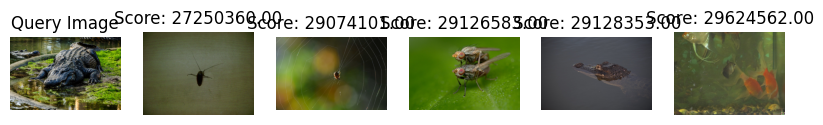

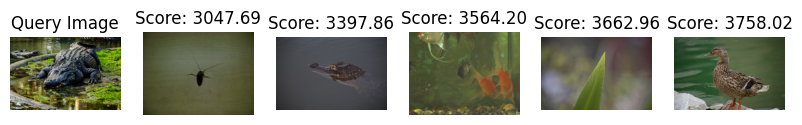

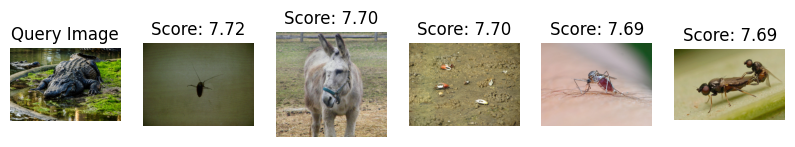

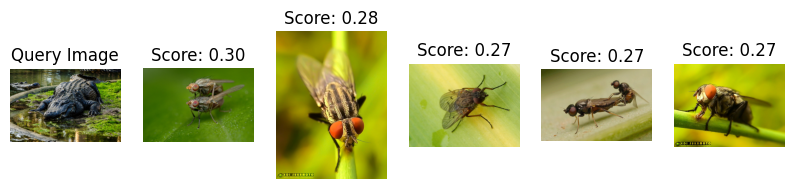

In [21]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Alligator/16007953602_7b9aed7ed0_b.jpg"
size = (448, 448)

# Truy vấn với L1
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

# Truy vấn với L2
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

# Truy vấn với Cosine Similarity
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

# Truy vấn với Correlation Coefficient
query, ls_path_score = get_correlation_coefficient_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

# Nâng cao chương trình truy vấn ảnh

In [22]:
!pip install chromadb
!pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 26.3 MB/s eta 0:00:0

In [23]:
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

## Hàm trích xuất vector đặc trưng từ mô hình CLIP

In [24]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=image)
    return np.array(embedding)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

## Các hàm truy vấn hình ảnh với các độ đo khác nhau

In [25]:
def get_l1_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = absolute_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

def get_l2_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = mean_square_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

def get_cosine_similarity_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = cosine_similarity(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

def get_correlation_coefficient_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = correlation_coefficient(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

## Chạy chương trình với các độ đo khác nhau

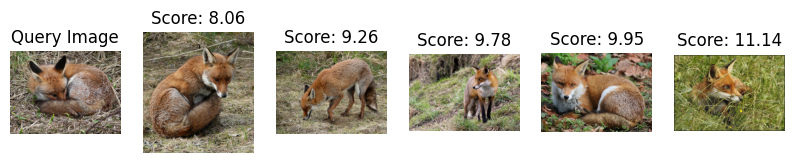

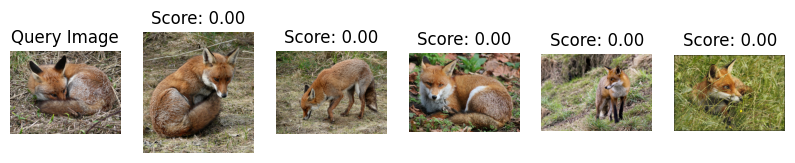

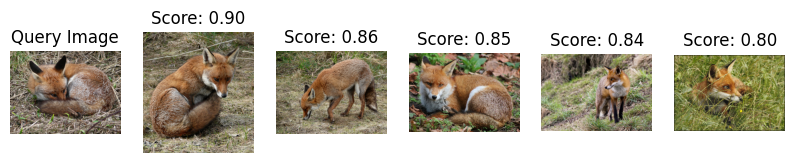

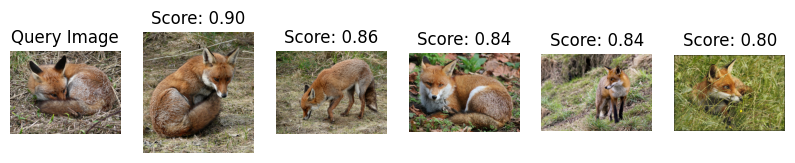

In [26]:
root_img_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Fox/13486614834_eaa4fd95aa_b.jpg"
size = (448, 448)

# Truy vấn với L1
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

# Truy vấn với L2
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

# Truy vấn với Cosine Similarity
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

# Truy vấn với Correlation Coefficient
query, ls_path_score = get_correlation_coefficient_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)